In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

%load_ext autoreload
%autoreload 2

In [2]:
with open("data/pkl_files/trimmed_inputs.pkl", "rb") as fp:
    inputs = pickle.load(fp)
with open("data/pkl_files/trimmed_outputs.pkl", "rb") as fp:
    outputs = pickle.load(fp)

In [ ]:
# inputs = np.reshape(complete_inputs[:,0:3,:,:], (complete_inputs.shape[0], 3, complete_inputs.shape[2], complete_inputs.shape[3]))


In [3]:
# Sanity check
print(inputs.shape)
print(outputs.shape)

(25650, 4, 32, 32)
(25650, 1, 32, 32)


In [4]:
outputs[outputs > 0] = 1

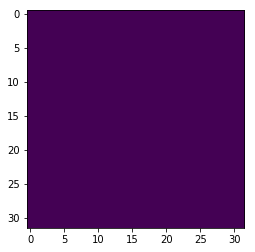

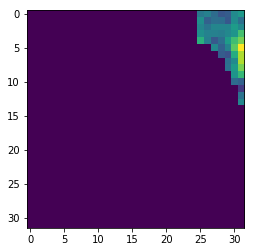

In [5]:
# Sanity Check
idx = np.random.randint(0, inputs.shape[0])
def plot_sampled_images(idx):    
    cropped_seg_img = outputs[idx,0,:,:]
    plt.imshow(cropped_seg_img)
    plt.show()
    cropped_flair_img = inputs[idx,0,:,:]
    plt.imshow(cropped_flair_img)
    plt.show()
plot_sampled_images(idx)

In [6]:
np.random.seed(0)
shuffled_idxs = list(range(inputs.shape[0]))
np.random.shuffle(shuffled_idxs)
train_cutoff = int(inputs.shape[0]*80/100)
val_cutoff = int(inputs.shape[0]*90/100)

train_inputs = []
train_outputs = []
val_inputs = []
val_outputs = []
test_inputs = []
test_outputs = []

for iteration, idx in enumerate(shuffled_idxs):
    if iteration < train_cutoff:
        train_inputs.append(inputs[idx])
        train_outputs.append(outputs[idx])
    elif iteration < val_cutoff:
        val_inputs.append(inputs[idx])
        val_outputs.append(outputs[idx])
    else:
        test_inputs.append(inputs[idx])
        test_outputs.append(outputs[idx])

In [7]:
# sanity check
print(len(train_inputs))
print(len(train_outputs))
print(len(val_inputs))
print(len(val_outputs))
print(len(test_inputs))
print(len(test_outputs))

20520
20520
2565
2565
2565
2565


In [8]:
train_inputs = np.asarray(train_inputs).astype(np.float32)
val_inputs = np.asarray(val_inputs).astype(np.float32)
test_inputs = np.asarray(test_inputs).astype(np.float32)

train_inputs_mean = np.mean(train_inputs, axis=0)
train_inputs_std = np.std(train_inputs, axis=0)

train_inputs -= train_inputs_mean
train_inputs /= train_inputs_std
val_inputs -= train_inputs_mean
val_inputs /= train_inputs_std
test_inputs -= train_inputs_mean
test_inputs /= train_inputs_std

In [9]:
train_outputs = np.asarray(train_outputs).astype(np.float32)
n_tumor_pixels = np.count_nonzero(train_outputs)
total_output_pixels = train_outputs.shape[0]*train_outputs.shape[2]*train_outputs.shape[3]
frac_tumor = n_tumor_pixels / total_output_pixels
print(frac_tumor)

0.06759054618969298


In [10]:
train_data = []
val_data = []
test_data = []

for idx in range(train_inputs.shape[0]):
    train_data.append([train_inputs[idx], train_outputs[idx]])
for idx in range(val_inputs.shape[0]):
    val_data.append([val_inputs[idx], val_outputs[idx]])
for idx in range(test_inputs.shape[0]):
    test_data.append([test_inputs[idx], test_outputs[idx]])

In [11]:
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=32)

print(len(train_loader))
print(len(train_data))

642
20520


In [12]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial
print(torch.cuda.is_available())

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

True
using device: cuda


In [13]:
from models.unet import *

In [14]:
"""
in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
"""
def test_UNet():
    channels_in = 4
    n_classes = 2
    x = torch.zeros((32, 4, 32, 32), dtype=dtype)
    model = UNet(channel_in=channels_in, classes=n_classes)
    scores = model(x)
    print(scores.size())
test_UNet()

torch.Size([32, 2, 32, 32])


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [25]:
# Defining all parameters 
print_every = 25
loss_history = []
learning_rate = 0.5e-2
input_channels = 4
n_classes = 2
model = UNet(channel_in=input_channels, classes=n_classes)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99), eps=1e-08, weight_decay=learning_rate/float(250), amsgrad=False)
# criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, n_blank_pixel/float(n_tumor_pixels)]).cuda()) 
criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, (total_output_pixels-n_tumor_pixels)/float(n_tumor_pixels)]).cuda()) 
# could try dice loss? not sure how it would work nor how it expects its parameters though lol

if USE_GPU and torch.cuda.is_available():
    model.cuda()

In [16]:
def create_masks(x):
    mask = np.zeros((n_classes, x.shape[0], x.shape[1]))
    for c in range(n_classes):
        mask[c] = x == c
    return mask

In [17]:
def compute_iou(scores, output):  
    scores = scores.astype(np.bool)
    output = output.astype(np.bool)
    overlap = scores*output
    union = scores+output # Logical OR
    IOU = (overlap.sum())/(float(union.sum())+1e-10) 
    return IOU

In [18]:
def iou_metric(preds, labels):
    # preds and labels are of size (64, 32, 32)
    # return average iou value for each class
    numpy_preds = preds.cpu().numpy()  
    numpy_labels = labels.cpu().numpy()
    
    iou_tracker = np.zeros((numpy_preds.shape[0], n_classes))
    # get the masks
    for idx in range(numpy_preds.shape[0]):
        """plt.title('Segmented Output')
        plt.imshow(numpy_preds[idx,:,:])
        plt.show()
        plt.title('Ground Truth')
        plt.imshow(numpy_labels[idx,:,:])
        plt.show()"""
        pred_mask = create_masks(numpy_preds[idx])
        label_mask = create_masks(numpy_labels[idx])
        for c in range(n_classes):
            iou_tracker[idx, c] = compute_iou(pred_mask[c], label_mask[c])
        # print(iou_tracker[idx])
    # print(np.mean(iou_tracker, axis=0))
    return np.mean(iou_tracker, axis=0)     

In [19]:
def check_iou(loader, model):
    all_iou = np.zeros((len(loader),n_classes))

    with torch.no_grad():
        for t, (x,y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float).view(y.shape[0], 32, 32)
            scores = model(x)
            _, preds = scores.max(1)
            
            all_iou[t] = iou_metric(preds, y)
    # print(np.mean(all_iou, axis=0))
    return np.mean(all_iou, axis=0)

In [20]:
check_iou(val_loader, model)

array([0.93777044, 0.        ])

In [21]:
def plot_output(scores, y):
    with torch.no_grad():
        _, preds = scores.max(1)
        numpy_scores = preds.cpu().numpy().astype(np.uint8)
        numpy_truth = y.cpu().numpy().astype(np.uint8)
        idx = np.random.randint(1, y.shape[0])
        while(np.count_nonzero(numpy_truth[idx]) < int(0.10*32*32)):
            idx = np.random.randint(1, y.shape[0])
        plt.title('Segmented Output')
        plt.imshow(numpy_scores[idx,:,:])
        plt.show()
        plt.title('Ground Truth')
        plt.imshow(numpy_truth[idx,:,:])
        plt.show()

In [22]:
import torch.nn.functional as F
train_loss_history = []
val_loss_history = []
cur_epoch_train_loss = []
cur_epoch_val_loss = []
averaged_train_loss_hist = []
averaged_val_loss_history = []
val_iou_history = []
train_iou_history = []

plot_every = 100
def train(model, optimizer, epochs=1):
    
    model = model.to(device=device)
    
    train_loss_history.clear()
    val_loss_history.clear()
    cur_epoch_train_loss.clear()
    cur_epoch_val_loss.clear()
    averaged_train_loss_hist.clear()
    averaged_val_loss_history.clear()
    val_iou_history.clear()
    train_iou_history.clear()
    
    for e in range(epochs):
        cur_epoch_train_loss.clear()
        cur_epoch_val_loss.clear()
        for t, (x,y) in enumerate(train_loader):
            model.train()
            x = x.to(device=device, dtype=dtype)
            labels = y.to(device=device, dtype=torch.long).view(y.shape[0], 32, 32)
            # print(labels.shape)

            train_scores = model(x)
            train_loss = criterion(train_scores, labels)
            train_loss_history.append(train_loss.item())
            cur_epoch_train_loss.append(train_loss.item())
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

        for t, (x,y) in enumerate(val_loader):
            model.eval()
            x = x.to(device=device, dtype=dtype)
            labels = y.to(device=device, dtype=torch.long).view(y.shape[0], 32, 32)
            
            val_scores = model(x)
            val_loss = criterion(val_scores, labels)
            val_loss_history.append(val_loss.item())
            cur_epoch_val_loss.append(val_loss.item())
            
        averaged_train_loss_hist.append(np.mean(np.asarray(cur_epoch_train_loss)))
        averaged_val_loss_history.append(np.mean(np.asarray(cur_epoch_val_loss)))
        print('Epoch %d, Average Training Loss = %.4f, Average Validation Loss = %.4f' % \
              (e, np.mean(np.asarray(cur_epoch_train_loss)), np.mean(np.asarray(cur_epoch_val_loss))))
        val_iou = check_iou(val_loader, model)
        val_iou_history.append(val_iou)
        train_iou = check_iou(train_loader, model)
        train_iou_history.append(train_iou)
        print('Validation IOU: ', val_iou)
        print('Training IOU: ', train_iou)


In [23]:
train(model, optimizer, epochs=250)

Epoch 0, Iteration 0, loss = 0.7456
Validation IOU:  [0.93605332 0.        ]
Training IOU:  [9.32391733e-01 5.29662812e-08]
Epoch 0, Iteration 25, loss = 0.7010
Validation IOU:  [9.37518072e-01 3.56342897e-05]
Training IOU:  [9.32309458e-01 3.76160262e-05]
Epoch 0, Iteration 50, loss = 0.6615
Validation IOU:  [9.35760362e-01 6.84094874e-04]
Training IOU:  [9.30531752e-01 7.57151047e-04]
Epoch 0, Iteration 75, loss = 0.6569
Validation IOU:  [0.88806128 0.01434511]
Training IOU:  [0.88542324 0.016006  ]
Epoch 0, Iteration 100, loss = 0.6618
Validation IOU:  [0.8590847  0.02124245]
Training IOU:  [0.85554179 0.02353472]
Epoch 0, Iteration 125, loss = 0.6629
Validation IOU:  [0.7636753 0.0390129]
Training IOU:  [0.76025689 0.04144201]
Epoch 0, Iteration 150, loss = 0.6283
Validation IOU:  [0.6526315  0.05405025]
Training IOU:  [0.64729242 0.05824202]
Epoch 0, Iteration 175, loss = 0.6109
Validation IOU:  [0.59132735 0.05787827]
Training IOU:  [0.59172905 0.06334963]
Epoch 0, Iteration 200,

Validation IOU:  [0.74456966 0.07085305]
Training IOU:  [0.75174227 0.07742989]
Epoch 2, Iteration 425, loss = 0.4854
Validation IOU:  [0.72158092 0.07225548]
Training IOU:  [0.72543611 0.07815079]
Epoch 2, Iteration 450, loss = 0.4437
Validation IOU:  [0.6870405  0.07253037]
Training IOU:  [0.68763329 0.07755786]
Epoch 2, Iteration 475, loss = 0.5075
Validation IOU:  [0.71363662 0.07042618]
Training IOU:  [0.71824577 0.07780207]
Epoch 2, Iteration 500, loss = 0.4355
Validation IOU:  [0.72240082 0.06858394]
Training IOU:  [0.7296018  0.07605536]
Epoch 2, Iteration 525, loss = 0.5045
Validation IOU:  [0.70260951 0.07042079]
Training IOU:  [0.70633672 0.07687447]
Epoch 2, Iteration 550, loss = 0.5668
Validation IOU:  [0.68317011 0.07093028]
Training IOU:  [0.68805498 0.07825309]
Epoch 2, Iteration 575, loss = 0.4476
Validation IOU:  [0.67936729 0.07042889]
Training IOU:  [0.68859266 0.07796202]
Epoch 2, Iteration 600, loss = 0.5182
Validation IOU:  [0.71620541 0.07066705]
Training IOU:  

Epoch 5, Iteration 150, loss = 0.4929
Validation IOU:  [0.71228321 0.07621647]
Training IOU:  [0.71761878 0.08196306]
Epoch 5, Iteration 175, loss = 0.4779
Validation IOU:  [0.76291395 0.07358222]
Training IOU:  [0.76675747 0.08107759]
Epoch 5, Iteration 200, loss = 0.4433
Validation IOU:  [0.77229739 0.07415516]
Training IOU:  [0.77662609 0.07892056]
Epoch 5, Iteration 225, loss = 0.5486
Validation IOU:  [0.75353573 0.07246894]
Training IOU:  [0.75650053 0.08001767]
Epoch 5, Iteration 250, loss = 0.4511
Validation IOU:  [0.73263394 0.07374153]
Training IOU:  [0.74274889 0.08272601]
Epoch 5, Iteration 275, loss = 0.4697
Validation IOU:  [0.73778781 0.0740547 ]
Training IOU:  [0.74355211 0.08190869]
Epoch 5, Iteration 300, loss = 0.4371
Validation IOU:  [0.75354901 0.07402884]
Training IOU:  [0.76336684 0.08109505]
Epoch 5, Iteration 325, loss = 0.4427
Validation IOU:  [0.76195186 0.07498334]
Training IOU:  [0.7643948  0.08242446]
Epoch 5, Iteration 350, loss = 0.5490
Validation IOU:  [

Epoch 7, Iteration 575, loss = 0.5427
Validation IOU:  [0.78209985 0.0755718 ]
Training IOU:  [0.78826773 0.08417549]
Epoch 7, Iteration 600, loss = 0.4939
Validation IOU:  [0.77568224 0.07409397]
Training IOU:  [0.7822203  0.08369977]
Epoch 7, Iteration 625, loss = 0.4673
Validation IOU:  [0.79243757 0.07197227]
Training IOU:  [0.80180981 0.08274331]
Epoch 7, Average Training Loss = 0.4819, Average Validation Loss = 0.4796
Epoch 8, Iteration 0, loss = 0.4564
Validation IOU:  [0.7906856  0.07080187]
Training IOU:  [0.79828199 0.08198295]
Epoch 8, Iteration 25, loss = 0.4509
Validation IOU:  [0.77980229 0.07402224]
Training IOU:  [0.78462939 0.08152553]
Epoch 8, Iteration 50, loss = 0.4732
Validation IOU:  [0.77677066 0.07196855]
Training IOU:  [0.78719853 0.08139532]
Epoch 8, Iteration 75, loss = 0.4634
Validation IOU:  [0.80023971 0.0714373 ]
Training IOU:  [0.80888515 0.08252232]
Epoch 8, Iteration 100, loss = 0.4118
Validation IOU:  [0.79914967 0.0713876 ]
Training IOU:  [0.80500402

Epoch 10, Iteration 325, loss = 0.4034
Validation IOU:  [0.793694   0.07085755]
Training IOU:  [0.79975266 0.08103142]
Epoch 10, Iteration 350, loss = 0.5288
Validation IOU:  [0.76006213 0.07360387]
Training IOU:  [0.76830044 0.08433628]
Epoch 10, Iteration 375, loss = 0.4754
Validation IOU:  [0.76994338 0.0753361 ]
Training IOU:  [0.77527376 0.08635367]
Epoch 10, Iteration 400, loss = 0.4557
Validation IOU:  [0.79226128 0.06983102]
Training IOU:  [0.80089925 0.08344297]
Epoch 10, Iteration 425, loss = 0.4371
Validation IOU:  [0.80137286 0.07451621]
Training IOU:  [0.80680933 0.08522615]
Epoch 10, Iteration 450, loss = 0.5790
Validation IOU:  [0.77548828 0.07373794]
Training IOU:  [0.78090644 0.08502653]
Epoch 10, Iteration 475, loss = 0.4157
Validation IOU:  [0.77237469 0.0755775 ]
Training IOU:  [0.77840507 0.0868348 ]
Epoch 10, Iteration 500, loss = 0.4249
Validation IOU:  [0.783966   0.07438712]
Training IOU:  [0.78920589 0.08549529]
Epoch 10, Iteration 525, loss = 0.4024
Validatio

Validation IOU:  [0.81520121 0.07466874]
Training IOU:  [0.82439925 0.08818897]
Epoch 13, Iteration 75, loss = 0.4805
Validation IOU:  [0.8105533  0.07837742]
Training IOU:  [0.81567719 0.08787244]
Epoch 13, Iteration 100, loss = 0.4486
Validation IOU:  [0.79403908 0.0746639 ]
Training IOU:  [0.80082589 0.08598207]
Epoch 13, Iteration 125, loss = 0.4398
Validation IOU:  [0.77798753 0.07423919]
Training IOU:  [0.78566252 0.08620427]
Epoch 13, Iteration 150, loss = 0.4254
Validation IOU:  [0.75636408 0.07528088]
Training IOU:  [0.76569713 0.08636976]
Epoch 13, Iteration 175, loss = 0.4340
Validation IOU:  [0.76870046 0.07687468]
Training IOU:  [0.77905093 0.0887984 ]
Epoch 13, Iteration 200, loss = 0.4409
Validation IOU:  [0.75229136 0.07716202]
Training IOU:  [0.76221991 0.08817683]
Epoch 13, Iteration 225, loss = 0.4415
Validation IOU:  [0.78741136 0.07387708]
Training IOU:  [0.79740431 0.08544056]
Epoch 13, Iteration 250, loss = 0.4293
Validation IOU:  [0.78621973 0.07675687]
Training

Validation IOU:  [0.7954506  0.08101627]
Training IOU:  [0.80378761 0.0908192 ]
Epoch 15, Iteration 475, loss = 0.4518
Validation IOU:  [0.80424009 0.07420929]
Training IOU:  [0.81432386 0.09088709]
Epoch 15, Iteration 500, loss = 0.4386
Validation IOU:  [0.80419158 0.07725985]
Training IOU:  [0.81475927 0.09085248]
Epoch 15, Iteration 525, loss = 0.4825
Validation IOU:  [0.80586379 0.07343606]
Training IOU:  [0.81600534 0.08937684]
Epoch 15, Iteration 550, loss = 0.3819
Validation IOU:  [0.80282675 0.07346352]
Training IOU:  [0.81478906 0.08927452]
Epoch 15, Iteration 575, loss = 0.5065
Validation IOU:  [0.81031086 0.07807817]
Training IOU:  [0.81939558 0.09077173]
Epoch 15, Iteration 600, loss = 0.4987
Validation IOU:  [0.79070797 0.07575252]
Training IOU:  [0.80301944 0.09074678]
Epoch 15, Iteration 625, loss = 0.4491
Validation IOU:  [0.79911813 0.07644726]
Training IOU:  [0.80960233 0.0917878 ]
Epoch 15, Average Training Loss = 0.4550, Average Validation Loss = 0.4801
Epoch 16, It

Epoch 18, Iteration 200, loss = 0.3953
Validation IOU:  [0.80080591 0.07432416]
Training IOU:  [0.81128082 0.09027566]
Epoch 18, Iteration 225, loss = 0.4070
Validation IOU:  [0.80191957 0.07705086]
Training IOU:  [0.8148222  0.09202055]
Epoch 18, Iteration 250, loss = 0.4919
Validation IOU:  [0.79868797 0.07626824]
Training IOU:  [0.81011161 0.09129473]
Epoch 18, Iteration 275, loss = 0.4447
Validation IOU:  [0.78479233 0.07673967]
Training IOU:  [0.7932052  0.09025834]
Epoch 18, Iteration 300, loss = 0.5059
Validation IOU:  [0.77983303 0.07924633]
Training IOU:  [0.78645733 0.09126238]
Epoch 18, Iteration 325, loss = 0.4210
Validation IOU:  [0.79382554 0.07606178]
Training IOU:  [0.80717451 0.09204562]
Epoch 18, Iteration 350, loss = 0.5176
Validation IOU:  [0.78874063 0.07871382]
Training IOU:  [0.80222415 0.09175842]
Epoch 18, Iteration 375, loss = 0.3942
Validation IOU:  [0.79378048 0.07829153]
Training IOU:  [0.8052211  0.09216879]
Epoch 18, Iteration 400, loss = 0.4271
Validatio

Epoch 20, Iteration 600, loss = 0.5184
Validation IOU:  [0.81724832 0.07594201]
Training IOU:  [0.83073789 0.09069256]
Epoch 20, Iteration 625, loss = 0.4752
Validation IOU:  [0.80167186 0.07679638]
Training IOU:  [0.81446096 0.0922157 ]
Epoch 20, Average Training Loss = 0.4424, Average Validation Loss = 0.4740
Epoch 21, Iteration 0, loss = 0.4475
Validation IOU:  [0.78844411 0.0788644 ]
Training IOU:  [0.79843649 0.09292796]
Epoch 21, Iteration 25, loss = 0.4964
Validation IOU:  [0.77421446 0.07820573]
Training IOU:  [0.78583774 0.09117283]
Epoch 21, Iteration 50, loss = 0.4774
Validation IOU:  [0.79263764 0.07661008]
Training IOU:  [0.80480121 0.09072815]
Epoch 21, Iteration 75, loss = 0.4854
Validation IOU:  [0.79598598 0.07865345]
Training IOU:  [0.81160945 0.09262068]
Epoch 21, Iteration 100, loss = 0.5178
Validation IOU:  [0.8006068  0.07334994]
Training IOU:  [0.8140566  0.09215869]
Epoch 21, Iteration 125, loss = 0.4200
Validation IOU:  [0.81057047 0.07448372]
Training IOU:  [0

Validation IOU:  [0.81863735 0.07507026]
Training IOU:  [0.8299715  0.09323849]
Epoch 23, Iteration 350, loss = 0.4261
Validation IOU:  [0.82541241 0.07582282]
Training IOU:  [0.83578905 0.09266385]
Epoch 23, Iteration 375, loss = 0.4686
Validation IOU:  [0.81636089 0.07416601]
Training IOU:  [0.83082385 0.09346893]
Epoch 23, Iteration 400, loss = 0.4806
Validation IOU:  [0.82463322 0.07649156]
Training IOU:  [0.83633132 0.09285313]
Epoch 23, Iteration 425, loss = 0.4551
Validation IOU:  [0.81995988 0.07606877]
Training IOU:  [0.83435039 0.09455718]
Epoch 23, Iteration 450, loss = 0.4219
Validation IOU:  [0.82839581 0.07328867]
Training IOU:  [0.83986861 0.09192728]
Epoch 23, Iteration 475, loss = 0.4363
Validation IOU:  [0.81069714 0.07335351]
Training IOU:  [0.82802383 0.09287096]
Epoch 23, Iteration 500, loss = 0.4398
Validation IOU:  [0.81067741 0.07461692]
Training IOU:  [0.8265343  0.09250604]
Epoch 23, Iteration 525, loss = 0.4177
Validation IOU:  [0.79871606 0.07566122]
Trainin

Epoch 26, Iteration 75, loss = 0.4003
Validation IOU:  [0.82172417 0.07655562]
Training IOU:  [0.835833   0.09349061]
Epoch 26, Iteration 100, loss = 0.4469
Validation IOU:  [0.83097603 0.07240297]
Training IOU:  [0.8468335  0.09536977]
Epoch 26, Iteration 125, loss = 0.3746
Validation IOU:  [0.81903138 0.07747059]
Training IOU:  [0.83250727 0.0962175 ]
Epoch 26, Iteration 150, loss = 0.4685
Validation IOU:  [0.82658069 0.07512967]
Training IOU:  [0.8407828  0.09450259]
Epoch 26, Iteration 175, loss = 0.4325
Validation IOU:  [0.80922007 0.07576307]
Training IOU:  [0.82431496 0.09396713]
Epoch 26, Iteration 200, loss = 0.4576
Validation IOU:  [0.78873034 0.07688962]
Training IOU:  [0.80523652 0.09384923]
Epoch 26, Iteration 225, loss = 0.4381
Validation IOU:  [0.8025626  0.07706063]
Training IOU:  [0.81693079 0.09592788]
Epoch 26, Iteration 250, loss = 0.4761
Validation IOU:  [0.8099583  0.07633494]
Training IOU:  [0.82488567 0.09546027]
Epoch 26, Iteration 275, loss = 0.3897
Validation

Epoch 28, Iteration 475, loss = 0.4161
Validation IOU:  [0.82894285 0.07718691]
Training IOU:  [0.84447638 0.09572014]
Epoch 28, Iteration 500, loss = 0.3987
Validation IOU:  [0.82332435 0.07471372]
Training IOU:  [0.83954554 0.09343729]
Epoch 28, Iteration 525, loss = 0.4076
Validation IOU:  [0.81857931 0.07716197]
Training IOU:  [0.83492648 0.09529661]
Epoch 28, Iteration 550, loss = 0.4203
Validation IOU:  [0.82288319 0.07624795]
Training IOU:  [0.83840549 0.09705132]
Epoch 28, Iteration 575, loss = 0.4241
Validation IOU:  [0.8065622  0.07954144]
Training IOU:  [0.82054158 0.09593714]
Epoch 28, Iteration 600, loss = 0.3909
Validation IOU:  [0.80808731 0.07659418]
Training IOU:  [0.82756743 0.0959151 ]
Epoch 28, Iteration 625, loss = 0.3868
Validation IOU:  [0.80497737 0.07738921]
Training IOU:  [0.82276679 0.09500167]
Epoch 28, Average Training Loss = 0.4304, Average Validation Loss = 0.4710
Epoch 29, Iteration 0, loss = 0.4587
Validation IOU:  [0.80624352 0.07655025]
Training IOU: 

Validation IOU:  [0.83574464 0.07314411]
Training IOU:  [0.85630273 0.09736881]
Epoch 31, Iteration 225, loss = 0.4260
Validation IOU:  [0.83239902 0.07452068]
Training IOU:  [0.85215252 0.0965127 ]
Epoch 31, Iteration 250, loss = 0.4088
Validation IOU:  [0.81585047 0.07489118]
Training IOU:  [0.82937718 0.09383977]
Epoch 31, Iteration 275, loss = 0.4980
Validation IOU:  [0.84532524 0.07394722]
Training IOU:  [0.8622774  0.09559129]
Epoch 31, Iteration 300, loss = 0.4562
Validation IOU:  [0.80488263 0.076189  ]
Training IOU:  [0.82371823 0.0972794 ]
Epoch 31, Iteration 325, loss = 0.4239
Validation IOU:  [0.81010178 0.07596667]
Training IOU:  [0.82645979 0.09624735]
Epoch 31, Iteration 350, loss = 0.3848
Validation IOU:  [0.83055587 0.07574406]
Training IOU:  [0.84727275 0.0964761 ]
Epoch 31, Iteration 375, loss = 0.4503
Validation IOU:  [0.82966592 0.07753797]
Training IOU:  [0.84549899 0.09846178]
Epoch 31, Iteration 400, loss = 0.4559
Validation IOU:  [0.82682242 0.07813157]
Trainin

Epoch 33, Iteration 600, loss = 0.4257
Validation IOU:  [0.84669749 0.07393224]
Training IOU:  [0.86206953 0.09773533]
Epoch 33, Iteration 625, loss = 0.3633
Validation IOU:  [0.83523469 0.07427364]
Training IOU:  [0.85078451 0.09687283]
Epoch 33, Average Training Loss = 0.4181, Average Validation Loss = 0.5042
Epoch 34, Iteration 0, loss = 0.4110
Validation IOU:  [0.81391687 0.07483291]
Training IOU:  [0.8314541  0.09742708]
Epoch 34, Iteration 25, loss = 0.4390
Validation IOU:  [0.81373768 0.0745397 ]
Training IOU:  [0.83321128 0.09701167]
Epoch 34, Iteration 50, loss = 0.4479
Validation IOU:  [0.83124011 0.07354238]
Training IOU:  [0.85063977 0.09634302]
Epoch 34, Iteration 75, loss = 0.3766
Validation IOU:  [0.82490526 0.07383606]
Training IOU:  [0.84450822 0.09688849]
Epoch 34, Iteration 100, loss = 0.3804
Validation IOU:  [0.82931887 0.07334318]
Training IOU:  [0.84705724 0.09438137]
Epoch 34, Iteration 125, loss = 0.4059
Validation IOU:  [0.81584614 0.0784221 ]
Training IOU:  [0

Validation IOU:  [0.80065672 0.07682499]
Training IOU:  [0.81851912 0.09676764]
Epoch 36, Iteration 350, loss = 0.3995
Validation IOU:  [0.82390793 0.07756387]
Training IOU:  [0.84080385 0.09884263]
Epoch 36, Iteration 375, loss = 0.3884
Validation IOU:  [0.83931689 0.07657911]
Training IOU:  [0.85891479 0.10059547]
Epoch 36, Iteration 400, loss = 0.3889
Validation IOU:  [0.83003242 0.07433615]
Training IOU:  [0.84770352 0.09841047]
Epoch 36, Iteration 425, loss = 0.4661
Validation IOU:  [0.83743561 0.07785598]
Training IOU:  [0.85682842 0.09911658]
Epoch 36, Iteration 450, loss = 0.4145
Validation IOU:  [0.82033271 0.07648058]
Training IOU:  [0.83626357 0.0968565 ]
Epoch 36, Iteration 475, loss = 0.3966
Validation IOU:  [0.8385244  0.07469563]
Training IOU:  [0.85786339 0.0996467 ]
Epoch 36, Iteration 500, loss = 0.4149
Validation IOU:  [0.81003636 0.07777616]
Training IOU:  [0.82849067 0.09766683]
Epoch 36, Iteration 525, loss = 0.3974
Validation IOU:  [0.80641167 0.07565951]
Trainin

Epoch 39, Iteration 75, loss = 0.3664
Validation IOU:  [0.82792448 0.07675508]
Training IOU:  [0.84776852 0.0964854 ]
Epoch 39, Iteration 100, loss = 0.3793
Validation IOU:  [0.84011549 0.07693814]
Training IOU:  [0.85904789 0.09965961]
Epoch 39, Iteration 125, loss = 0.4590
Validation IOU:  [0.84907533 0.0740024 ]
Training IOU:  [0.86754021 0.09959954]
Epoch 39, Iteration 150, loss = 0.3675
Validation IOU:  [0.8394401  0.07448357]
Training IOU:  [0.85952421 0.09924654]
Epoch 39, Iteration 175, loss = 0.3771
Validation IOU:  [0.8536828  0.07160105]
Training IOU:  [0.87240317 0.10038799]
Epoch 39, Iteration 200, loss = 0.4316
Validation IOU:  [0.81753444 0.07601855]
Training IOU:  [0.83457236 0.0981357 ]
Epoch 39, Iteration 225, loss = 0.4404
Validation IOU:  [0.84737419 0.07513335]
Training IOU:  [0.86496081 0.10041795]
Epoch 39, Iteration 250, loss = 0.3785
Validation IOU:  [0.84824399 0.07496679]
Training IOU:  [0.86618302 0.10090838]
Epoch 39, Iteration 275, loss = 0.3647
Validation

Epoch 41, Iteration 475, loss = 0.3886
Validation IOU:  [0.8381942  0.07658552]
Training IOU:  [0.85441481 0.0999207 ]
Epoch 41, Iteration 500, loss = 0.3747
Validation IOU:  [0.85147341 0.07543022]
Training IOU:  [0.86678022 0.10028935]
Epoch 41, Iteration 525, loss = 0.3803
Validation IOU:  [0.82696323 0.07661585]
Training IOU:  [0.84274556 0.09868761]
Epoch 41, Iteration 550, loss = 0.4371
Validation IOU:  [0.82100777 0.07616379]
Training IOU:  [0.84171141 0.09889287]
Epoch 41, Iteration 575, loss = 0.3748
Validation IOU:  [0.83851743 0.0741371 ]
Training IOU:  [0.86066479 0.10027259]
Epoch 41, Iteration 600, loss = 0.4573
Validation IOU:  [0.84685764 0.07675664]
Training IOU:  [0.86261449 0.1009838 ]
Epoch 41, Iteration 625, loss = 0.4204
Validation IOU:  [0.83988259 0.07306598]
Training IOU:  [0.85798667 0.09902503]
Epoch 41, Average Training Loss = 0.4065, Average Validation Loss = 0.4798
Epoch 42, Iteration 0, loss = 0.4939
Validation IOU:  [0.82998712 0.0767429 ]
Training IOU: 

Validation IOU:  [0.83632757 0.07346256]
Training IOU:  [0.85514864 0.10060661]
Epoch 44, Iteration 225, loss = 0.3812
Validation IOU:  [0.84027883 0.07237402]
Training IOU:  [0.8597778  0.10080375]
Epoch 44, Iteration 250, loss = 0.4607
Validation IOU:  [0.82269195 0.07401372]
Training IOU:  [0.84326061 0.0994041 ]
Epoch 44, Iteration 275, loss = 0.3608
Validation IOU:  [0.83761373 0.07466618]
Training IOU:  [0.85738079 0.10154888]
Epoch 44, Iteration 300, loss = 0.4299
Validation IOU:  [0.85116752 0.07457984]
Training IOU:  [0.86884394 0.10333119]
Epoch 44, Iteration 325, loss = 0.4061
Validation IOU:  [0.84358315 0.07433346]
Training IOU:  [0.8610679 0.1006791]
Epoch 44, Iteration 350, loss = 0.4855
Validation IOU:  [0.8456905  0.07436189]
Training IOU:  [0.86681778 0.10266267]
Epoch 44, Iteration 375, loss = 0.4025
Validation IOU:  [0.83094674 0.07652103]
Training IOU:  [0.84728019 0.10159146]
Epoch 44, Iteration 400, loss = 0.4027
Validation IOU:  [0.85776406 0.07467684]
Training 

Validation IOU:  [0.8236877  0.07686864]
Training IOU:  [0.84490912 0.10117993]
Epoch 46, Iteration 625, loss = 0.3816
Validation IOU:  [0.85130682 0.07284949]
Training IOU:  [0.87305946 0.10276642]
Epoch 46, Average Training Loss = 0.4023, Average Validation Loss = 0.4923
Epoch 47, Iteration 0, loss = 0.4162
Validation IOU:  [0.86257882 0.0743258 ]
Training IOU:  [0.88073372 0.10182052]
Epoch 47, Iteration 25, loss = 0.3985
Validation IOU:  [0.85005467 0.07342113]
Training IOU:  [0.86660883 0.1005039 ]
Epoch 47, Iteration 50, loss = 0.4078
Validation IOU:  [0.86114906 0.07528519]
Training IOU:  [0.87789408 0.10265818]
Epoch 47, Iteration 75, loss = 0.3698
Validation IOU:  [0.85849812 0.07535051]
Training IOU:  [0.8756417  0.10284558]
Epoch 47, Iteration 100, loss = 0.3991
Validation IOU:  [0.86455277 0.07417752]
Training IOU:  [0.8815274  0.10343659]
Epoch 47, Iteration 125, loss = 0.3805
Validation IOU:  [0.83828608 0.07826014]
Training IOU:  [0.8557524  0.10112452]
Epoch 47, Iterati

Epoch 49, Iteration 350, loss = 0.3481
Validation IOU:  [0.83901608 0.07477305]
Training IOU:  [0.86041873 0.10126637]
Epoch 49, Iteration 375, loss = 0.4223
Validation IOU:  [0.85022298 0.07631123]
Training IOU:  [0.86921639 0.1027085 ]
Epoch 49, Iteration 400, loss = 0.4288
Validation IOU:  [0.86044113 0.07536723]
Training IOU:  [0.87878887 0.10272131]
Epoch 49, Iteration 425, loss = 0.3833
Validation IOU:  [0.85837834 0.07168124]
Training IOU:  [0.87563947 0.10300573]
Epoch 49, Iteration 450, loss = 0.3698
Validation IOU:  [0.85504641 0.07351029]
Training IOU:  [0.87373819 0.10360405]
Epoch 49, Iteration 475, loss = 0.4123
Validation IOU:  [0.83136941 0.07641476]
Training IOU:  [0.85036525 0.10224366]
Epoch 49, Iteration 500, loss = 0.3865
Validation IOU:  [0.85402667 0.07407606]
Training IOU:  [0.87147316 0.10368045]
Epoch 49, Iteration 525, loss = 0.5555
Validation IOU:  [0.82016888 0.07515156]
Training IOU:  [0.8380315  0.09907277]
Epoch 49, Iteration 550, loss = 0.4247
Validatio

Validation IOU:  [0.84913782 0.07286507]
Training IOU:  [0.86844454 0.10141484]
Epoch 52, Iteration 100, loss = 0.4075
Validation IOU:  [0.84671575 0.07354958]
Training IOU:  [0.86499071 0.10156546]
Epoch 52, Iteration 125, loss = 0.4124
Validation IOU:  [0.84441339 0.07448286]
Training IOU:  [0.86246267 0.10102131]
Epoch 52, Iteration 150, loss = 0.4333
Validation IOU:  [0.86571468 0.07217876]
Training IOU:  [0.88358402 0.1023878 ]
Epoch 52, Iteration 175, loss = 0.4117
Validation IOU:  [0.85911787 0.0711804 ]
Training IOU:  [0.87822477 0.10222814]
Epoch 52, Iteration 200, loss = 0.4156
Validation IOU:  [0.859552   0.07345606]
Training IOU:  [0.8777597  0.10280913]
Epoch 52, Iteration 225, loss = 0.3425
Validation IOU:  [0.86344117 0.07398036]
Training IOU:  [0.88062937 0.1008668 ]
Epoch 52, Iteration 250, loss = 0.3910
Validation IOU:  [0.8598365  0.07206108]
Training IOU:  [0.87904971 0.10282911]
Epoch 52, Iteration 275, loss = 0.4171
Validation IOU:  [0.85520457 0.07230274]
Trainin

Validation IOU:  [0.84321493 0.07281262]
Training IOU:  [0.86749173 0.10431171]
Epoch 54, Iteration 500, loss = 0.3654
Validation IOU:  [0.83423723 0.07694949]
Training IOU:  [0.85427377 0.10293107]
Epoch 54, Iteration 525, loss = 0.3945
Validation IOU:  [0.87062884 0.06994044]
Training IOU:  [0.8888166  0.10360415]
Epoch 54, Iteration 550, loss = 0.3804
Validation IOU:  [0.84695425 0.07577934]
Training IOU:  [0.86554911 0.10311905]
Epoch 54, Iteration 575, loss = 0.3613
Validation IOU:  [0.85983313 0.07313611]
Training IOU:  [0.87707147 0.10401668]
Epoch 54, Iteration 600, loss = 0.3904
Validation IOU:  [0.84364081 0.07510155]
Training IOU:  [0.86233018 0.10200152]
Epoch 54, Iteration 625, loss = 0.3599
Validation IOU:  [0.85759958 0.07492431]
Training IOU:  [0.87550791 0.10410954]
Epoch 54, Average Training Loss = 0.3932, Average Validation Loss = 0.4915
Epoch 55, Iteration 0, loss = 0.3632
Validation IOU:  [0.8408281  0.07570172]
Training IOU:  [0.85923973 0.10299522]
Epoch 55, Iter

Epoch 57, Iteration 225, loss = 0.3586
Validation IOU:  [0.86529505 0.07250174]
Training IOU:  [0.88272759 0.10413746]
Epoch 57, Iteration 250, loss = 0.3696
Validation IOU:  [0.85860205 0.071112  ]
Training IOU:  [0.87788067 0.1038175 ]
Epoch 57, Iteration 275, loss = 0.4674
Validation IOU:  [0.84416956 0.0739536 ]
Training IOU:  [0.86585517 0.10313952]
Epoch 57, Iteration 300, loss = 0.3716
Validation IOU:  [0.86670546 0.0701529 ]
Training IOU:  [0.89040959 0.10376938]
Epoch 57, Iteration 325, loss = 0.4125
Validation IOU:  [0.84133554 0.07451661]
Training IOU:  [0.86374049 0.10155129]
Epoch 57, Iteration 350, loss = 0.4158
Validation IOU:  [0.85078664 0.0747898 ]
Training IOU:  [0.87230142 0.10304268]
Epoch 57, Iteration 375, loss = 0.4039
Validation IOU:  [0.85087162 0.07453214]
Training IOU:  [0.87213514 0.10332767]
Epoch 57, Iteration 400, loss = 0.3692
Validation IOU:  [0.85379554 0.0739757 ]
Training IOU:  [0.87346732 0.10362266]
Epoch 57, Iteration 425, loss = 0.3733
Validatio

Epoch 59, Iteration 625, loss = 0.3457
Validation IOU:  [0.85563079 0.07529766]
Training IOU:  [0.87299338 0.10443648]
Epoch 59, Average Training Loss = 0.3881, Average Validation Loss = 0.4829
Epoch 60, Iteration 0, loss = 0.3598
Validation IOU:  [0.86257246 0.07425913]
Training IOU:  [0.88069535 0.10497062]
Epoch 60, Iteration 25, loss = 0.3642
Validation IOU:  [0.87754414 0.07167796]
Training IOU:  [0.8935746  0.10581982]
Epoch 60, Iteration 50, loss = 0.3637
Validation IOU:  [0.85724804 0.07658959]
Training IOU:  [0.87854482 0.10420642]
Epoch 60, Iteration 75, loss = 0.3803
Validation IOU:  [0.87193155 0.07016151]
Training IOU:  [0.8902022  0.10459247]
Epoch 60, Iteration 100, loss = 0.3738
Validation IOU:  [0.86247906 0.07237837]
Training IOU:  [0.88229667 0.10642518]
Epoch 60, Iteration 125, loss = 0.3568
Validation IOU:  [0.87033617 0.07064776]
Training IOU:  [0.88876995 0.10468227]
Epoch 60, Iteration 150, loss = 0.4079
Validation IOU:  [0.86077911 0.07242643]
Training IOU:  [0

Validation IOU:  [0.85737954 0.07316949]
Training IOU:  [0.87650542 0.10526642]
Epoch 62, Iteration 375, loss = 0.3646
Validation IOU:  [0.86354604 0.07328245]
Training IOU:  [0.8817143  0.10499148]
Epoch 62, Iteration 400, loss = 0.3623
Validation IOU:  [0.86365531 0.07126172]
Training IOU:  [0.88389602 0.10587741]
Epoch 62, Iteration 425, loss = 0.3411
Validation IOU:  [0.86958956 0.06973034]
Training IOU:  [0.89022141 0.10719574]
Epoch 62, Iteration 450, loss = 0.3658
Validation IOU:  [0.86745854 0.07214083]
Training IOU:  [0.88785389 0.10685637]
Epoch 62, Iteration 475, loss = 0.3715
Validation IOU:  [0.86448434 0.07336945]
Training IOU:  [0.88334279 0.10598556]
Epoch 62, Iteration 500, loss = 0.3599
Validation IOU:  [0.86907084 0.06941759]
Training IOU:  [0.88939058 0.10669641]
Epoch 62, Iteration 525, loss = 0.3630
Validation IOU:  [0.85476305 0.07216526]
Training IOU:  [0.87483454 0.10469317]
Epoch 62, Iteration 550, loss = 0.4250
Validation IOU:  [0.87948815 0.0680395 ]
Trainin

Epoch 65, Iteration 100, loss = 0.3669
Validation IOU:  [0.88312284 0.07380434]
Training IOU:  [0.89834966 0.10471638]
Epoch 65, Iteration 125, loss = 0.3623
Validation IOU:  [0.87441636 0.07075112]
Training IOU:  [0.89046619 0.10512568]
Epoch 65, Iteration 150, loss = 0.3753
Validation IOU:  [0.86229959 0.07438529]
Training IOU:  [0.88136092 0.10649909]
Epoch 65, Iteration 175, loss = 0.3692
Validation IOU:  [0.8721392  0.07099859]
Training IOU:  [0.89287267 0.10638783]
Epoch 65, Iteration 200, loss = 0.4219
Validation IOU:  [0.8486153  0.07401272]
Training IOU:  [0.87049633 0.10490706]
Epoch 65, Iteration 225, loss = 0.4187
Validation IOU:  [0.87074259 0.07169874]
Training IOU:  [0.89094145 0.10691799]
Epoch 65, Iteration 250, loss = 0.3716
Validation IOU:  [0.86023995 0.0744301 ]
Training IOU:  [0.87857957 0.10545454]
Epoch 65, Iteration 275, loss = 0.3562
Validation IOU:  [0.88023498 0.07013365]
Training IOU:  [0.89820056 0.10800266]
Epoch 65, Iteration 300, loss = 0.3875
Validatio

Epoch 67, Iteration 500, loss = 0.4018
Validation IOU:  [0.87285191 0.07162937]
Training IOU:  [0.89289785 0.10652577]
Epoch 67, Iteration 525, loss = 0.3752
Validation IOU:  [0.85521436 0.07330557]
Training IOU:  [0.87616329 0.10592201]
Epoch 67, Iteration 550, loss = 0.3654
Validation IOU:  [0.87198723 0.07273159]
Training IOU:  [0.8932453  0.10776756]
Epoch 67, Iteration 575, loss = 0.3571
Validation IOU:  [0.86000428 0.07425873]
Training IOU:  [0.88142667 0.10509913]
Epoch 67, Iteration 600, loss = 0.3782
Validation IOU:  [0.82355395 0.0757839 ]
Training IOU:  [0.84361229 0.10137664]
Epoch 67, Iteration 625, loss = 0.4055
Validation IOU:  [0.87502892 0.07109763]
Training IOU:  [0.89353092 0.10633617]
Epoch 67, Average Training Loss = 0.3830, Average Validation Loss = 0.5003
Epoch 68, Iteration 0, loss = 0.4003
Validation IOU:  [0.88439925 0.0695478 ]
Training IOU:  [0.90245385 0.10743662]
Epoch 68, Iteration 25, loss = 0.3522
Validation IOU:  [0.86620282 0.07388096]
Training IOU:  

Validation IOU:  [0.86846495 0.07067434]
Training IOU:  [0.88818355 0.10643262]
Epoch 70, Iteration 250, loss = 0.3790
Validation IOU:  [0.86114263 0.07276075]
Training IOU:  [0.88230598 0.1068184 ]
Epoch 70, Iteration 275, loss = 0.3742
Validation IOU:  [0.86610429 0.07088106]
Training IOU:  [0.88519335 0.10573616]
Epoch 70, Iteration 300, loss = 0.3562
Validation IOU:  [0.84875572 0.07514955]
Training IOU:  [0.87050956 0.10433142]
Epoch 70, Iteration 325, loss = 0.3986
Validation IOU:  [0.87535869 0.07038122]
Training IOU:  [0.89574204 0.10774742]
Epoch 70, Iteration 350, loss = 0.3776
Validation IOU:  [0.8416792 0.0715778]
Training IOU:  [0.86225633 0.10321716]
Epoch 70, Iteration 375, loss = 0.3515
Validation IOU:  [0.87853438 0.06983011]
Training IOU:  [0.89793555 0.10903601]
Epoch 70, Iteration 400, loss = 0.3725
Validation IOU:  [0.86954425 0.07120913]
Training IOU:  [0.89200288 0.10730692]
Epoch 70, Iteration 425, loss = 0.3914
Validation IOU:  [0.86552553 0.07182247]
Training 

Validation IOU:  [0.87647894 0.0711723 ]
Training IOU:  [0.89692967 0.10765167]
Epoch 72, Average Training Loss = 0.3788, Average Validation Loss = 0.4828
Epoch 73, Iteration 0, loss = 0.3456
Validation IOU:  [0.85852236 0.07227134]
Training IOU:  [0.88032955 0.10512908]
Epoch 73, Iteration 25, loss = 0.3635
Validation IOU:  [0.88880858 0.06657512]
Training IOU:  [0.9087094  0.10769332]
Epoch 73, Iteration 50, loss = 0.3758
Validation IOU:  [0.86381481 0.07112132]
Training IOU:  [0.88524666 0.1063957 ]
Epoch 73, Iteration 75, loss = 0.3589
Validation IOU:  [0.8414777  0.07208685]
Training IOU:  [0.86606825 0.10314367]
Epoch 73, Iteration 100, loss = 0.3852
Validation IOU:  [0.85694796 0.07469009]
Training IOU:  [0.87813719 0.10447358]
Epoch 73, Iteration 125, loss = 0.3847
Validation IOU:  [0.88130956 0.0696595 ]
Training IOU:  [0.90136316 0.10829258]
Epoch 73, Iteration 150, loss = 0.3423
Validation IOU:  [0.83839774 0.07575299]
Training IOU:  [0.85941939 0.10470502]
Epoch 73, Iterati

Epoch 75, Iteration 375, loss = 0.3631
Validation IOU:  [0.87832316 0.06772878]
Training IOU:  [0.89925565 0.10901639]
Epoch 75, Iteration 400, loss = 0.3656
Validation IOU:  [0.86576965 0.07231158]
Training IOU:  [0.88612316 0.10737063]
Epoch 75, Iteration 425, loss = 0.3677
Validation IOU:  [0.88742564 0.07051277]
Training IOU:  [0.90726471 0.10921627]
Epoch 75, Iteration 450, loss = 0.3680
Validation IOU:  [0.86240241 0.07196704]
Training IOU:  [0.88471037 0.10664707]
Epoch 75, Iteration 475, loss = 0.4674
Validation IOU:  [0.87413552 0.07342254]
Training IOU:  [0.89445009 0.1071574 ]
Epoch 75, Iteration 500, loss = 0.3490
Validation IOU:  [0.86546979 0.07228883]
Training IOU:  [0.88657414 0.10592977]
Epoch 75, Iteration 525, loss = 0.3805
Validation IOU:  [0.8303315  0.07460275]
Training IOU:  [0.8562124  0.10334149]
Epoch 75, Iteration 550, loss = 0.3688
Validation IOU:  [0.86721792 0.0722152 ]
Training IOU:  [0.88759263 0.10605943]
Epoch 75, Iteration 575, loss = 0.4794
Validatio

Validation IOU:  [0.86988633 0.06984547]
Training IOU:  [0.88984156 0.10766967]
Epoch 78, Iteration 125, loss = 0.3849
Validation IOU:  [0.8723124  0.06814287]
Training IOU:  [0.8927843  0.10749714]
Epoch 78, Iteration 150, loss = 0.3451
Validation IOU:  [0.86988659 0.06894523]
Training IOU:  [0.89365121 0.10813967]
Epoch 78, Iteration 175, loss = 0.3750
Validation IOU:  [0.84301565 0.07401543]
Training IOU:  [0.86551352 0.10440755]
Epoch 78, Iteration 200, loss = 0.4243
Validation IOU:  [0.84875801 0.06883701]
Training IOU:  [0.86977349 0.1036733 ]
Epoch 78, Iteration 225, loss = 0.4032
Validation IOU:  [0.85932031 0.07233176]
Training IOU:  [0.87988546 0.10496505]
Epoch 78, Iteration 250, loss = 0.3563
Validation IOU:  [0.87293159 0.06869044]
Training IOU:  [0.89053369 0.10669204]
Epoch 78, Iteration 275, loss = 0.3983
Validation IOU:  [0.88279484 0.06402439]
Training IOU:  [0.90342257 0.10839354]
Epoch 78, Iteration 300, loss = 0.4114
Validation IOU:  [0.84816668 0.07382674]
Trainin

Validation IOU:  [0.86059254 0.07461423]
Training IOU:  [0.88228627 0.10738435]
Epoch 80, Iteration 525, loss = 0.3811
Validation IOU:  [0.86387939 0.07431793]
Training IOU:  [0.88608586 0.1071724 ]
Epoch 80, Iteration 550, loss = 0.4053
Validation IOU:  [0.87829777 0.06765886]
Training IOU:  [0.90101645 0.10868655]
Epoch 80, Iteration 575, loss = 0.4320
Validation IOU:  [0.86426873 0.07368313]
Training IOU:  [0.88434761 0.10628417]
Epoch 80, Iteration 600, loss = 0.3459
Validation IOU:  [0.88592835 0.06980952]
Training IOU:  [0.90274176 0.10969519]
Epoch 80, Iteration 625, loss = 0.3546
Validation IOU:  [0.87459552 0.0722155 ]
Training IOU:  [0.89682491 0.11088162]
Epoch 80, Average Training Loss = 0.3717, Average Validation Loss = 0.5045
Epoch 81, Iteration 0, loss = 0.3432
Validation IOU:  [0.87804621 0.0711584 ]
Training IOU:  [0.89864096 0.11017093]
Epoch 81, Iteration 25, loss = 0.3741
Validation IOU:  [0.84871308 0.07433812]
Training IOU:  [0.87044379 0.10415974]
Epoch 81, Itera

Epoch 83, Iteration 250, loss = 0.3830
Validation IOU:  [0.89900668 0.06287987]
Training IOU:  [0.9170601  0.10991868]
Epoch 83, Iteration 275, loss = 0.3938
Validation IOU:  [0.8645288  0.07302424]
Training IOU:  [0.88758719 0.10782917]
Epoch 83, Iteration 300, loss = 0.3890
Validation IOU:  [0.8618908  0.07248663]
Training IOU:  [0.88504846 0.1074953 ]
Epoch 83, Iteration 325, loss = 0.3695
Validation IOU:  [0.88814165 0.06396006]
Training IOU:  [0.91246431 0.11114357]
Epoch 83, Iteration 350, loss = 0.3973
Validation IOU:  [0.85828218 0.07052148]
Training IOU:  [0.88138612 0.1070889 ]
Epoch 83, Iteration 375, loss = 0.4004
Validation IOU:  [0.86385484 0.07272411]
Training IOU:  [0.88513792 0.10840378]
Epoch 83, Iteration 400, loss = 0.3692
Validation IOU:  [0.87146288 0.07133374]
Training IOU:  [0.89498049 0.10922548]
Epoch 83, Iteration 425, loss = 0.3776
Validation IOU:  [0.87101282 0.07102554]
Training IOU:  [0.890542   0.10841295]
Epoch 83, Iteration 450, loss = 0.3821
Validatio

Epoch 85, Average Training Loss = 0.3745, Average Validation Loss = 0.5219
Epoch 86, Iteration 0, loss = 0.3389
Validation IOU:  [0.8707134 0.0729444]
Training IOU:  [0.89345048 0.10847991]
Epoch 86, Iteration 25, loss = 0.4200
Validation IOU:  [0.88356568 0.06782559]
Training IOU:  [0.90856906 0.11055306]
Epoch 86, Iteration 50, loss = 0.3568
Validation IOU:  [0.85573744 0.07139412]
Training IOU:  [0.8797734  0.10669416]
Epoch 86, Iteration 75, loss = 0.3467
Validation IOU:  [0.8894176  0.06698809]
Training IOU:  [0.90957558 0.10990055]
Epoch 86, Iteration 100, loss = 0.3689
Validation IOU:  [0.86950045 0.069849  ]
Training IOU:  [0.89189109 0.10702484]
Epoch 86, Iteration 125, loss = 0.4038
Validation IOU:  [0.87405863 0.07083667]
Training IOU:  [0.8946372  0.10853364]
Epoch 86, Iteration 150, loss = 0.3394
Validation IOU:  [0.88562473 0.06684844]
Training IOU:  [0.90471917 0.11020367]
Epoch 86, Iteration 175, loss = 0.4062
Validation IOU:  [0.854367   0.07439974]
Training IOU:  [0.8

Validation IOU:  [0.88423554 0.06594629]
Training IOU:  [0.91000687 0.11077554]
Epoch 88, Iteration 400, loss = 0.3928
Validation IOU:  [0.86766322 0.06926069]
Training IOU:  [0.88963486 0.10739267]
Epoch 88, Iteration 425, loss = 0.3498
Validation IOU:  [0.88013745 0.06860488]
Training IOU:  [0.9022731  0.10962501]
Epoch 88, Iteration 450, loss = 0.3714
Validation IOU:  [0.87464288 0.07061852]
Training IOU:  [0.89551377 0.10898403]
Epoch 88, Iteration 475, loss = 0.3429
Validation IOU:  [0.87041966 0.07438236]
Training IOU:  [0.89366878 0.10828259]
Epoch 88, Iteration 500, loss = 0.3633
Validation IOU:  [0.87390188 0.07047108]
Training IOU:  [0.89832945 0.10909792]
Epoch 88, Iteration 525, loss = 0.3553
Validation IOU:  [0.87610817 0.07215963]
Training IOU:  [0.89581344 0.10917271]
Epoch 88, Iteration 550, loss = 0.3780
Validation IOU:  [0.86907267 0.06999019]
Training IOU:  [0.89500937 0.10906425]
Epoch 88, Iteration 575, loss = 0.3325
Validation IOU:  [0.87722727 0.07157188]
Trainin

Epoch 91, Iteration 125, loss = 0.3424
Validation IOU:  [0.88002471 0.06924746]
Training IOU:  [0.90334545 0.11175778]
Epoch 91, Iteration 150, loss = 0.3605
Validation IOU:  [0.88594157 0.06856274]
Training IOU:  [0.90843587 0.11301075]
Epoch 91, Iteration 175, loss = 0.3567
Validation IOU:  [0.88635224 0.06762927]
Training IOU:  [0.90971133 0.11251483]
Epoch 91, Iteration 200, loss = 0.3743
Validation IOU:  [0.87705887 0.06827162]
Training IOU:  [0.90037238 0.11114314]
Epoch 91, Iteration 225, loss = 0.3696
Validation IOU:  [0.87260811 0.07053975]
Training IOU:  [0.90038302 0.11041694]
Epoch 91, Iteration 250, loss = 0.4230
Validation IOU:  [0.87463507 0.0705933 ]
Training IOU:  [0.89644432 0.10837243]
Epoch 91, Iteration 275, loss = 0.3539
Validation IOU:  [0.8803751  0.06601257]
Training IOU:  [0.90090505 0.10859508]
Epoch 91, Iteration 300, loss = 0.3546
Validation IOU:  [0.87729906 0.06967384]
Training IOU:  [0.89959458 0.11007555]
Epoch 91, Iteration 325, loss = 0.3986
Validatio

Epoch 93, Iteration 525, loss = 0.3623
Validation IOU:  [0.88615765 0.06828506]
Training IOU:  [0.90591953 0.11025722]
Epoch 93, Iteration 550, loss = 0.3453
Validation IOU:  [0.86457156 0.07245383]
Training IOU:  [0.88773541 0.10862274]
Epoch 93, Iteration 575, loss = 0.4441
Validation IOU:  [0.8602546  0.07042989]
Training IOU:  [0.8816415  0.10842555]
Epoch 93, Iteration 600, loss = 0.3668
Validation IOU:  [0.88177149 0.06643504]
Training IOU:  [0.90408177 0.11005083]
Epoch 93, Iteration 625, loss = 0.3581
Validation IOU:  [0.87203553 0.07005571]
Training IOU:  [0.8942552  0.10858202]
Epoch 93, Average Training Loss = 0.3710, Average Validation Loss = 0.4977
Epoch 94, Iteration 0, loss = 0.4537
Validation IOU:  [0.84771772 0.07152105]
Training IOU:  [0.87371141 0.10522862]
Epoch 94, Iteration 25, loss = 0.3519
Validation IOU:  [0.89158462 0.06748699]
Training IOU:  [0.9120914  0.11168058]
Epoch 94, Iteration 50, loss = 0.3593
Validation IOU:  [0.88649382 0.06675089]
Training IOU:  [

Validation IOU:  [0.87493448 0.07102556]
Training IOU:  [0.89928795 0.11105243]
Epoch 96, Iteration 275, loss = 0.3701
Validation IOU:  [0.8696507  0.06912175]
Training IOU:  [0.89668834 0.10973756]
Epoch 96, Iteration 300, loss = 0.3568
Validation IOU:  [0.88035377 0.06754293]
Training IOU:  [0.90663016 0.11126628]
Epoch 96, Iteration 325, loss = 0.3654
Validation IOU:  [0.86982541 0.06827814]
Training IOU:  [0.89692746 0.10934574]
Epoch 96, Iteration 350, loss = 0.3669
Validation IOU:  [0.88493108 0.06648367]
Training IOU:  [0.91015398 0.1123629 ]
Epoch 96, Iteration 375, loss = 0.3509
Validation IOU:  [0.87606843 0.06833152]
Training IOU:  [0.90176314 0.11038761]
Epoch 96, Iteration 400, loss = 0.3594
Validation IOU:  [0.88271805 0.06758299]
Training IOU:  [0.90462004 0.11082083]
Epoch 96, Iteration 425, loss = 0.3458
Validation IOU:  [0.86686223 0.06852132]
Training IOU:  [0.896691   0.10991775]
Epoch 96, Iteration 450, loss = 0.3416
Validation IOU:  [0.86450191 0.07190139]
Trainin

Validation IOU:  [0.8795523  0.06946443]
Training IOU:  [0.904093   0.11078092]
Epoch 99, Iteration 25, loss = 0.3702
Validation IOU:  [0.88314591 0.06711558]
Training IOU:  [0.90698955 0.11102097]
Epoch 99, Iteration 50, loss = 0.3577
Validation IOU:  [0.88960342 0.06854677]
Training IOU:  [0.91028247 0.11279733]
Epoch 99, Iteration 75, loss = 0.3644
Validation IOU:  [0.87670509 0.07020334]
Training IOU:  [0.90328653 0.11173354]
Epoch 99, Iteration 100, loss = 0.3427
Validation IOU:  [0.88431073 0.06808818]
Training IOU:  [0.90889206 0.11307333]
Epoch 99, Iteration 125, loss = 0.3332
Validation IOU:  [0.8878908  0.06882181]
Training IOU:  [0.90927809 0.11345083]
Epoch 99, Iteration 150, loss = 0.3711
Validation IOU:  [0.88255304 0.0682267 ]
Training IOU:  [0.9065425  0.11277048]
Epoch 99, Iteration 175, loss = 0.3672
Validation IOU:  [0.88263739 0.06844288]
Training IOU:  [0.90755812 0.11221719]
Epoch 99, Iteration 200, loss = 0.3486
Validation IOU:  [0.86800566 0.07372993]
Training I

Epoch 101, Iteration 400, loss = 0.3888
Validation IOU:  [0.89515905 0.0657706 ]
Training IOU:  [0.91654438 0.11353588]
Epoch 101, Iteration 425, loss = 0.3581
Validation IOU:  [0.84815005 0.07242666]
Training IOU:  [0.87271374 0.10620243]
Epoch 101, Iteration 450, loss = 0.3712
Validation IOU:  [0.85094811 0.07473229]
Training IOU:  [0.87814902 0.10684896]
Epoch 101, Iteration 475, loss = 0.3775
Validation IOU:  [0.8988175  0.06645106]
Training IOU:  [0.9201759  0.11388122]
Epoch 101, Iteration 500, loss = 0.3710
Validation IOU:  [0.8712482 0.0695235]
Training IOU:  [0.89640529 0.11099737]
Epoch 101, Iteration 525, loss = 0.3584
Validation IOU:  [0.87451637 0.06983106]
Training IOU:  [0.89889537 0.10972644]
Epoch 101, Iteration 550, loss = 0.4002
Validation IOU:  [0.88784789 0.06573189]
Training IOU:  [0.91203713 0.11215195]
Epoch 101, Iteration 575, loss = 0.3622
Validation IOU:  [0.87474306 0.0702297 ]
Training IOU:  [0.89650549 0.10975321]
Epoch 101, Iteration 600, loss = 0.3561
Va

Epoch 104, Iteration 125, loss = 0.3474
Validation IOU:  [0.88948513 0.06711479]
Training IOU:  [0.91214027 0.11371122]
Epoch 104, Iteration 150, loss = 0.3577
Validation IOU:  [0.88542475 0.06775621]
Training IOU:  [0.9083035  0.11370673]
Epoch 104, Iteration 175, loss = 0.3605
Validation IOU:  [0.88977348 0.06745136]
Training IOU:  [0.91148985 0.11429047]
Epoch 104, Iteration 200, loss = 0.3459
Validation IOU:  [0.89054093 0.06726462]
Training IOU:  [0.91080957 0.11257807]
Epoch 104, Iteration 225, loss = 0.3631
Validation IOU:  [0.89030356 0.06835881]
Training IOU:  [0.91112505 0.11349231]
Epoch 104, Iteration 250, loss = 0.3580
Validation IOU:  [0.8893692  0.06648524]
Training IOU:  [0.91015142 0.11395279]
Epoch 104, Iteration 275, loss = 0.3764
Validation IOU:  [0.87799247 0.07201852]
Training IOU:  [0.90260387 0.11138658]
Epoch 104, Iteration 300, loss = 0.3722
Validation IOU:  [0.88987434 0.0688095 ]
Training IOU:  [0.90955895 0.1123685 ]
Epoch 104, Iteration 325, loss = 0.3474


Validation IOU:  [0.89392941 0.06192279]
Training IOU:  [0.91632897 0.11235721]
Epoch 106, Iteration 525, loss = 0.3795
Validation IOU:  [0.86988682 0.07298901]
Training IOU:  [0.89433363 0.10966371]
Epoch 106, Iteration 550, loss = 0.3751
Validation IOU:  [0.86745963 0.07083393]
Training IOU:  [0.89165798 0.10929818]
Epoch 106, Iteration 575, loss = 0.3955
Validation IOU:  [0.89003746 0.06833141]
Training IOU:  [0.91450962 0.11343118]
Epoch 106, Iteration 600, loss = 0.3723
Validation IOU:  [0.87426788 0.0686322 ]
Training IOU:  [0.89935615 0.1111573 ]
Epoch 106, Iteration 625, loss = 0.3483
Validation IOU:  [0.89424466 0.06461431]
Training IOU:  [0.91904905 0.1138719 ]
Epoch 106, Average Training Loss = 0.3628, Average Validation Loss = 0.4977
Epoch 107, Iteration 0, loss = 0.3525
Validation IOU:  [0.87325248 0.07047728]
Training IOU:  [0.89761401 0.11068143]
Epoch 107, Iteration 25, loss = 0.3666
Validation IOU:  [0.88084506 0.0685249 ]
Training IOU:  [0.90609435 0.11087484]
Epoch 1

Epoch 109, Iteration 225, loss = 0.3789
Validation IOU:  [0.88572055 0.06731703]
Training IOU:  [0.90910283 0.11220384]
Epoch 109, Iteration 250, loss = 0.3625
Validation IOU:  [0.87393246 0.06677904]
Training IOU:  [0.90056698 0.11055029]
Epoch 109, Iteration 275, loss = 0.3412
Validation IOU:  [0.89145842 0.06353974]
Training IOU:  [0.91715443 0.11463774]
Epoch 109, Iteration 300, loss = 0.3990
Validation IOU:  [0.86593045 0.07135034]
Training IOU:  [0.89323617 0.1099695 ]
Epoch 109, Iteration 325, loss = 0.3602
Validation IOU:  [0.86498967 0.07154968]
Training IOU:  [0.89127855 0.10974428]
Epoch 109, Iteration 350, loss = 0.3547
Validation IOU:  [0.88341431 0.0679424 ]
Training IOU:  [0.90916105 0.11348733]
Epoch 109, Iteration 375, loss = 0.3791
Validation IOU:  [0.87481015 0.06957871]
Training IOU:  [0.89929233 0.11125988]
Epoch 109, Iteration 400, loss = 0.3426
Validation IOU:  [0.87993979 0.06829152]
Training IOU:  [0.90763436 0.11246083]
Epoch 109, Iteration 425, loss = 0.3676


Validation IOU:  [0.88788919 0.06413818]
Training IOU:  [0.91213862 0.11397135]
Epoch 111, Iteration 625, loss = 0.3621
Validation IOU:  [0.88687149 0.0684653 ]
Training IOU:  [0.90702322 0.11232065]
Epoch 111, Average Training Loss = 0.3629, Average Validation Loss = 0.5041
Epoch 112, Iteration 0, loss = 0.3777
Validation IOU:  [0.86528395 0.07117026]
Training IOU:  [0.8929066  0.10940539]
Epoch 112, Iteration 25, loss = 0.3368
Validation IOU:  [0.8813873  0.06885216]
Training IOU:  [0.90511868 0.11162039]
Epoch 112, Iteration 50, loss = 0.3665
Validation IOU:  [0.88519502 0.06902964]
Training IOU:  [0.9071025 0.1126357]
Epoch 112, Iteration 75, loss = 0.4560
Validation IOU:  [0.88262323 0.06733887]
Training IOU:  [0.90547641 0.11278548]
Epoch 112, Iteration 100, loss = 0.3434
Validation IOU:  [0.88434656 0.06674652]
Training IOU:  [0.90887246 0.11282335]
Epoch 112, Iteration 125, loss = 0.3644
Validation IOU:  [0.87281628 0.06908233]
Training IOU:  [0.89962549 0.11103914]
Epoch 112, 

Epoch 114, Iteration 325, loss = 0.3621
Validation IOU:  [0.87511421 0.06824003]
Training IOU:  [0.89897946 0.11038235]
Epoch 114, Iteration 350, loss = 0.3834
Validation IOU:  [0.88149942 0.0695253 ]
Training IOU:  [0.90330751 0.1116602 ]
Epoch 114, Iteration 375, loss = 0.3732
Validation IOU:  [0.88816685 0.06555492]
Training IOU:  [0.91120253 0.11297121]
Epoch 114, Iteration 400, loss = 0.3637
Validation IOU:  [0.87698659 0.06811781]
Training IOU:  [0.89937451 0.11189875]
Epoch 114, Iteration 425, loss = 0.3615
Validation IOU:  [0.88819701 0.06631344]
Training IOU:  [0.91348568 0.11360766]
Epoch 114, Iteration 450, loss = 0.4414
Validation IOU:  [0.84231532 0.07263113]
Training IOU:  [0.87043126 0.10540606]
Epoch 114, Iteration 475, loss = 0.3433
Validation IOU:  [0.9005314  0.06360214]
Training IOU:  [0.92104389 0.11415202]
Epoch 114, Iteration 500, loss = 0.3699
Validation IOU:  [0.86993726 0.06993287]
Training IOU:  [0.89596776 0.11105882]
Epoch 114, Iteration 525, loss = 0.3443


Epoch 117, Iteration 50, loss = 0.3739
Validation IOU:  [0.88567179 0.06586771]
Training IOU:  [0.9104343  0.11418324]
Epoch 117, Iteration 75, loss = 0.3396
Validation IOU:  [0.88716044 0.06904818]
Training IOU:  [0.90887913 0.11302329]
Epoch 117, Iteration 100, loss = 0.3622
Validation IOU:  [0.8916448  0.06668618]
Training IOU:  [0.91458891 0.11395772]
Epoch 117, Iteration 125, loss = 0.3629
Validation IOU:  [0.87123326 0.07205533]
Training IOU:  [0.89883395 0.1114317 ]
Epoch 117, Iteration 150, loss = 0.3312
Validation IOU:  [0.88504227 0.06899804]
Training IOU:  [0.9083969  0.11355298]
Epoch 117, Iteration 175, loss = 0.3496
Validation IOU:  [0.89667623 0.06436791]
Training IOU:  [0.9199539  0.11563318]
Epoch 117, Iteration 200, loss = 0.3548
Validation IOU:  [0.8800409  0.07312635]
Training IOU:  [0.90424181 0.11248776]
Epoch 117, Iteration 225, loss = 0.3633
Validation IOU:  [0.87174004 0.06559654]
Training IOU:  [0.89786943 0.11164109]
Epoch 117, Iteration 250, loss = 0.3442
Va

Validation IOU:  [0.88537541 0.06508833]
Training IOU:  [0.91096189 0.11304663]
Epoch 119, Iteration 450, loss = 0.3605
Validation IOU:  [0.85565736 0.07124356]
Training IOU:  [0.88429804 0.1069285 ]
Epoch 119, Iteration 475, loss = 0.3630
Validation IOU:  [0.89965535 0.06335063]
Training IOU:  [0.92018995 0.11380113]
Epoch 119, Iteration 500, loss = 0.3452
Validation IOU:  [0.85732684 0.07087997]
Training IOU:  [0.88572721 0.10892746]
Epoch 119, Iteration 525, loss = 0.3429
Validation IOU:  [0.88190315 0.06587377]
Training IOU:  [0.90835978 0.11330378]
Epoch 119, Iteration 550, loss = 0.3329
Validation IOU:  [0.88932209 0.0633781 ]
Training IOU:  [0.91438555 0.1135536 ]
Epoch 119, Iteration 575, loss = 0.3587
Validation IOU:  [0.84932614 0.07258415]
Training IOU:  [0.87697275 0.10782148]
Epoch 119, Iteration 600, loss = 0.3658
Validation IOU:  [0.89717915 0.06393418]
Training IOU:  [0.92233574 0.11482439]
Epoch 119, Iteration 625, loss = 0.3419
Validation IOU:  [0.87016523 0.0710905 ]

Epoch 122, Iteration 150, loss = 0.3751
Validation IOU:  [0.89558132 0.06566553]
Training IOU:  [0.91876047 0.11505658]
Epoch 122, Iteration 175, loss = 0.3647
Validation IOU:  [0.88105043 0.07006583]
Training IOU:  [0.90551619 0.11275912]
Epoch 122, Iteration 200, loss = 0.3670
Validation IOU:  [0.87858147 0.07145357]
Training IOU:  [0.90560735 0.11304258]
Epoch 122, Iteration 225, loss = 0.3293
Validation IOU:  [0.89657059 0.06717628]
Training IOU:  [0.9172526 0.1144927]
Epoch 122, Iteration 250, loss = 0.3548
Validation IOU:  [0.88279882 0.07192683]
Training IOU:  [0.90683699 0.1128332 ]
Epoch 122, Iteration 275, loss = 0.3572
Validation IOU:  [0.88822647 0.07191582]
Training IOU:  [0.910932   0.11290249]
Epoch 122, Iteration 300, loss = 0.3443
Validation IOU:  [0.8821239  0.06931275]
Training IOU:  [0.90478533 0.11157396]
Epoch 122, Iteration 325, loss = 0.3485
Validation IOU:  [0.89833222 0.06303624]
Training IOU:  [0.922217   0.11462807]
Epoch 122, Iteration 350, loss = 0.3686
Va

Validation IOU:  [0.87573675 0.06891494]
Training IOU:  [0.90436087 0.11227192]
Epoch 124, Iteration 550, loss = 0.3639
Validation IOU:  [0.88774688 0.06667895]
Training IOU:  [0.91571696 0.11467641]
Epoch 124, Iteration 575, loss = 0.3504
Validation IOU:  [0.87668088 0.07075645]
Training IOU:  [0.90122681 0.11043702]
Epoch 124, Iteration 600, loss = 0.3421
Validation IOU:  [0.89212148 0.06539963]
Training IOU:  [0.91691609 0.11387113]
Epoch 124, Iteration 625, loss = 0.3909
Validation IOU:  [0.87963534 0.06870879]
Training IOU:  [0.90503312 0.1118369 ]
Epoch 124, Average Training Loss = 0.3584, Average Validation Loss = 0.5548
Epoch 125, Iteration 0, loss = 0.3455
Validation IOU:  [0.90710592 0.06150198]
Training IOU:  [0.92844406 0.11673453]
Epoch 125, Iteration 25, loss = 0.3482
Validation IOU:  [0.86643504 0.07050942]
Training IOU:  [0.89608303 0.11101397]
Epoch 125, Iteration 50, loss = 0.3415
Validation IOU:  [0.89600394 0.0643138 ]
Training IOU:  [0.92249547 0.11510221]
Epoch 12

Epoch 127, Iteration 250, loss = 0.3374
Validation IOU:  [0.89343622 0.06413927]
Training IOU:  [0.91758795 0.11339269]
Epoch 127, Iteration 275, loss = 0.3405
Validation IOU:  [0.88740348 0.06748344]
Training IOU:  [0.91128467 0.11369369]
Epoch 127, Iteration 300, loss = 0.4091
Validation IOU:  [0.89995559 0.06597872]
Training IOU:  [0.92299808 0.11459061]
Epoch 127, Iteration 325, loss = 0.3608
Validation IOU:  [0.88602859 0.06831864]
Training IOU:  [0.91097153 0.1136432 ]
Epoch 127, Iteration 350, loss = 0.3457
Validation IOU:  [0.87857215 0.06927093]
Training IOU:  [0.90338805 0.11184076]
Epoch 127, Iteration 375, loss = 0.3427
Validation IOU:  [0.88638084 0.06943494]
Training IOU:  [0.91128771 0.11460288]
Epoch 127, Iteration 400, loss = 0.3702
Validation IOU:  [0.88944682 0.06699323]
Training IOU:  [0.91600431 0.11490969]
Epoch 127, Iteration 425, loss = 0.3547
Validation IOU:  [0.88957984 0.06689542]
Training IOU:  [0.91230989 0.11442336]
Epoch 127, Iteration 450, loss = 0.3567


Validation IOU:  [0.85887195 0.07453151]
Training IOU:  [0.88928212 0.11007626]
Epoch 129, Average Training Loss = 0.3596, Average Validation Loss = 0.5190
Epoch 130, Iteration 0, loss = 0.3469
Validation IOU:  [0.89090749 0.06754145]
Training IOU:  [0.9153585  0.11510128]
Epoch 130, Iteration 25, loss = 0.3327
Validation IOU:  [0.88497224 0.06683535]
Training IOU:  [0.91133932 0.11356598]
Epoch 130, Iteration 50, loss = 0.3585
Validation IOU:  [0.88667964 0.06784595]
Training IOU:  [0.91151461 0.11362753]
Epoch 130, Iteration 75, loss = 0.3570
Validation IOU:  [0.88917387 0.06604046]
Training IOU:  [0.91282345 0.11450722]
Epoch 130, Iteration 100, loss = 0.3352
Validation IOU:  [0.89129178 0.06559237]
Training IOU:  [0.91695158 0.11546855]
Epoch 130, Iteration 125, loss = 0.3378
Validation IOU:  [0.87104285 0.07129366]
Training IOU:  [0.89520121 0.1098218 ]
Epoch 130, Iteration 150, loss = 0.3519
Validation IOU:  [0.88085722 0.07020595]
Training IOU:  [0.90415739 0.1116837 ]
Epoch 130

Epoch 132, Iteration 350, loss = 0.3536
Validation IOU:  [0.88453508 0.07244902]
Training IOU:  [0.91047325 0.11508609]
Epoch 132, Iteration 375, loss = 0.3522
Validation IOU:  [0.87830013 0.0692946 ]
Training IOU:  [0.90815071 0.11434358]
Epoch 132, Iteration 400, loss = 0.3432
Validation IOU:  [0.88432982 0.06736353]
Training IOU:  [0.91136994 0.11515553]
Epoch 132, Iteration 425, loss = 0.3429
Validation IOU:  [0.89509484 0.06333404]
Training IOU:  [0.92279601 0.11708931]
Epoch 132, Iteration 450, loss = 0.3444
Validation IOU:  [0.89623715 0.06294906]
Training IOU:  [0.92342812 0.11678249]
Epoch 132, Iteration 475, loss = 0.3280
Validation IOU:  [0.88075234 0.06667994]
Training IOU:  [0.90967392 0.11353212]
Epoch 132, Iteration 500, loss = 0.3755
Validation IOU:  [0.8866505  0.06653853]
Training IOU:  [0.91052615 0.11343897]
Epoch 132, Iteration 525, loss = 0.3393
Validation IOU:  [0.89324851 0.06439021]
Training IOU:  [0.91915514 0.11571143]
Epoch 132, Iteration 550, loss = 0.3640


Epoch 135, Iteration 75, loss = 0.4438
Validation IOU:  [0.89297884 0.06584136]
Training IOU:  [0.92134536 0.11553906]
Epoch 135, Iteration 100, loss = 0.3494
Validation IOU:  [0.8828007  0.06837051]
Training IOU:  [0.91007021 0.11466067]
Epoch 135, Iteration 125, loss = 0.3434
Validation IOU:  [0.89969264 0.06474674]
Training IOU:  [0.92225814 0.1158904 ]
Epoch 135, Iteration 150, loss = 0.3318
Validation IOU:  [0.89181814 0.06600991]
Training IOU:  [0.91593458 0.11557949]
Epoch 135, Iteration 175, loss = 0.3435
Validation IOU:  [0.87694785 0.06991339]
Training IOU:  [0.90109617 0.11236172]
Epoch 135, Iteration 200, loss = 0.3456
Validation IOU:  [0.88337999 0.06729607]
Training IOU:  [0.90849223 0.11419838]
Epoch 135, Iteration 225, loss = 0.3608
Validation IOU:  [0.8933517  0.06344529]
Training IOU:  [0.91979134 0.11508889]
Epoch 135, Iteration 250, loss = 0.3469
Validation IOU:  [0.87045341 0.06864239]
Training IOU:  [0.89848491 0.11163362]
Epoch 135, Iteration 275, loss = 0.3565
V

Validation IOU:  [0.88773679 0.06651981]
Training IOU:  [0.91643067 0.11596633]
Epoch 137, Iteration 475, loss = 0.3642
Validation IOU:  [0.89110319 0.06662903]
Training IOU:  [0.91727334 0.11582824]
Epoch 137, Iteration 500, loss = 0.3552
Validation IOU:  [0.88511593 0.06664657]
Training IOU:  [0.91214062 0.11506607]
Epoch 137, Iteration 525, loss = 0.3623
Validation IOU:  [0.88718011 0.06748061]
Training IOU:  [0.91461356 0.11586408]
Epoch 137, Iteration 550, loss = 0.3593
Validation IOU:  [0.8821293  0.06790708]
Training IOU:  [0.90762027 0.11334815]
Epoch 137, Iteration 575, loss = 0.3615
Validation IOU:  [0.89111106 0.0648286 ]
Training IOU:  [0.91804928 0.11552171]
Epoch 137, Iteration 600, loss = 0.3554
Validation IOU:  [0.88034691 0.06889527]
Training IOU:  [0.90840545 0.11366335]
Epoch 137, Iteration 625, loss = 0.3573
Validation IOU:  [0.87689127 0.06948219]
Training IOU:  [0.90465656 0.11271463]
Epoch 137, Average Training Loss = 0.3563, Average Validation Loss = 0.5374
Epoc

Epoch 140, Iteration 175, loss = 0.3572
Validation IOU:  [0.88257168 0.06928704]
Training IOU:  [0.90813399 0.11334378]
Epoch 140, Iteration 200, loss = 0.4293
Validation IOU:  [0.88327244 0.06781483]
Training IOU:  [0.90920095 0.11292718]
Epoch 140, Iteration 225, loss = 0.3712
Validation IOU:  [0.88450301 0.06791058]
Training IOU:  [0.90928526 0.11373292]
Epoch 140, Iteration 250, loss = 0.3722
Validation IOU:  [0.89043318 0.06458598]
Training IOU:  [0.91749379 0.11597927]
Epoch 140, Iteration 275, loss = 0.3412
Validation IOU:  [0.87173344 0.06963059]
Training IOU:  [0.89948416 0.11224204]
Epoch 140, Iteration 300, loss = 0.3669
Validation IOU:  [0.87148594 0.06898642]
Training IOU:  [0.90286642 0.11207581]
Epoch 140, Iteration 325, loss = 0.3536
Validation IOU:  [0.87030843 0.0689904 ]
Training IOU:  [0.90027247 0.11099988]
Epoch 140, Iteration 350, loss = 0.3528
Validation IOU:  [0.8969393  0.06224618]
Training IOU:  [0.9201439  0.11536889]
Epoch 140, Iteration 375, loss = 0.3704


Validation IOU:  [0.88626552 0.06666985]
Training IOU:  [0.91203963 0.11492978]
Epoch 142, Iteration 575, loss = 0.3444
Validation IOU:  [0.88924216 0.06671946]
Training IOU:  [0.91446411 0.11554177]
Epoch 142, Iteration 600, loss = 0.3901
Validation IOU:  [0.87936226 0.06968567]
Training IOU:  [0.90442524 0.11290477]
Epoch 142, Iteration 625, loss = 0.3735
Validation IOU:  [0.89527943 0.0647102 ]
Training IOU:  [0.92070816 0.11682156]
Epoch 142, Average Training Loss = 0.3638, Average Validation Loss = 0.5256
Epoch 143, Iteration 0, loss = 0.3451
Validation IOU:  [0.89263524 0.06391158]
Training IOU:  [0.91621285 0.115049  ]
Epoch 143, Iteration 25, loss = 0.3458
Validation IOU:  [0.88839867 0.06979419]
Training IOU:  [0.91144186 0.11434638]
Epoch 143, Iteration 50, loss = 0.3618
Validation IOU:  [0.89478988 0.0665441 ]
Training IOU:  [0.91659336 0.11657753]
Epoch 143, Iteration 75, loss = 0.3432
Validation IOU:  [0.8949376  0.06436933]
Training IOU:  [0.91875477 0.11700354]
Epoch 143

Epoch 145, Iteration 275, loss = 0.3777
Validation IOU:  [0.8912915  0.06682492]
Training IOU:  [0.91843115 0.11608003]
Epoch 145, Iteration 300, loss = 0.3640
Validation IOU:  [0.89121826 0.06806432]
Training IOU:  [0.91859898 0.11699795]
Epoch 145, Iteration 325, loss = 0.3708
Validation IOU:  [0.88032271 0.07124215]
Training IOU:  [0.9049135  0.11316804]
Epoch 145, Iteration 350, loss = 0.3335
Validation IOU:  [0.89486907 0.06643314]
Training IOU:  [0.92054245 0.11757951]
Epoch 145, Iteration 375, loss = 0.3963
Validation IOU:  [0.87745375 0.06887885]
Training IOU:  [0.90329835 0.11257496]
Epoch 145, Iteration 400, loss = 0.3458
Validation IOU:  [0.89148875 0.06598149]
Training IOU:  [0.91799356 0.11616423]
Epoch 145, Iteration 425, loss = 0.3897
Validation IOU:  [0.89098563 0.06534026]
Training IOU:  [0.91825691 0.11619163]
Epoch 145, Iteration 450, loss = 0.3676
Validation IOU:  [0.89101298 0.06422998]
Training IOU:  [0.91612578 0.11603894]
Epoch 145, Iteration 475, loss = 0.3315


Validation IOU:  [0.88756936 0.06388923]
Training IOU:  [0.91487028 0.11598075]
Epoch 148, Iteration 25, loss = 0.3583
Validation IOU:  [0.86396787 0.07011613]
Training IOU:  [0.8954398  0.11050666]
Epoch 148, Iteration 50, loss = 0.3628
Validation IOU:  [0.90141561 0.05874064]
Training IOU:  [0.92896046 0.11818007]
Epoch 148, Iteration 75, loss = 0.3435
Validation IOU:  [0.88424669 0.06759941]
Training IOU:  [0.91112418 0.11544415]
Epoch 148, Iteration 100, loss = 0.3354
Validation IOU:  [0.88615895 0.0679314 ]
Training IOU:  [0.91377693 0.11559609]
Epoch 148, Iteration 125, loss = 0.3405
Validation IOU:  [0.89106151 0.06396985]
Training IOU:  [0.91849136 0.11687537]
Epoch 148, Iteration 150, loss = 0.3453
Validation IOU:  [0.89199507 0.06258994]
Training IOU:  [0.92064096 0.11691447]
Epoch 148, Iteration 175, loss = 0.3315
Validation IOU:  [0.88825381 0.06675697]
Training IOU:  [0.91465116 0.11617107]
Epoch 148, Iteration 200, loss = 0.3231
Validation IOU:  [0.89915388 0.06266035]
Tr

Epoch 150, Iteration 400, loss = 0.3754
Validation IOU:  [0.86799099 0.06914831]
Training IOU:  [0.89804793 0.11100062]
Epoch 150, Iteration 425, loss = 0.3431
Validation IOU:  [0.86664026 0.06893761]
Training IOU:  [0.89679952 0.11071111]
Epoch 150, Iteration 450, loss = 0.3515
Validation IOU:  [0.88636542 0.06587224]
Training IOU:  [0.91231372 0.11457998]
Epoch 150, Iteration 475, loss = 0.3705
Validation IOU:  [0.89296955 0.06553981]
Training IOU:  [0.91677813 0.11695058]
Epoch 150, Iteration 500, loss = 0.3841
Validation IOU:  [0.88358139 0.06723347]
Training IOU:  [0.9121478  0.11449025]
Epoch 150, Iteration 525, loss = 0.3532
Validation IOU:  [0.89282729 0.06437987]
Training IOU:  [0.91891731 0.11652671]
Epoch 150, Iteration 550, loss = 0.3537
Validation IOU:  [0.89922139 0.06290528]
Training IOU:  [0.92521685 0.11772541]
Epoch 150, Iteration 575, loss = 0.3633
Validation IOU:  [0.88333712 0.07038284]
Training IOU:  [0.91103564 0.113971  ]
Epoch 150, Iteration 600, loss = 0.3704


Epoch 153, Iteration 125, loss = 0.3580
Validation IOU:  [0.89079215 0.0652773 ]
Training IOU:  [0.91658873 0.11585949]
Epoch 153, Iteration 150, loss = 0.3470
Validation IOU:  [0.88213414 0.06811835]
Training IOU:  [0.91139875 0.11529658]
Epoch 153, Iteration 175, loss = 0.3305
Validation IOU:  [0.88245373 0.07109466]
Training IOU:  [0.90964805 0.11507613]
Epoch 153, Iteration 200, loss = 0.3676
Validation IOU:  [0.90099756 0.0650393 ]
Training IOU:  [0.92464898 0.11885928]
Epoch 153, Iteration 225, loss = 0.3628
Validation IOU:  [0.8458797  0.07367784]
Training IOU:  [0.88078243 0.10785325]
Epoch 153, Iteration 250, loss = 0.3473
Validation IOU:  [0.8893343  0.06419114]
Training IOU:  [0.91831173 0.11516483]
Epoch 153, Iteration 275, loss = 0.3351
Validation IOU:  [0.88285468 0.06981768]
Training IOU:  [0.90988956 0.11354625]
Epoch 153, Iteration 300, loss = 0.3411
Validation IOU:  [0.89254285 0.06404233]
Training IOU:  [0.9177786  0.11630201]
Epoch 153, Iteration 325, loss = 0.3633


Validation IOU:  [0.89227303 0.06437813]
Training IOU:  [0.9188424  0.11772801]
Epoch 155, Iteration 525, loss = 0.3590
Validation IOU:  [0.88799639 0.06450296]
Training IOU:  [0.91787387 0.11718971]
Epoch 155, Iteration 550, loss = 0.3392
Validation IOU:  [0.87209692 0.06946711]
Training IOU:  [0.90093688 0.11202344]
Epoch 155, Iteration 575, loss = 0.3635
Validation IOU:  [0.88621613 0.06613891]
Training IOU:  [0.91273101 0.11518236]
Epoch 155, Iteration 600, loss = 0.3423
Validation IOU:  [0.89773481 0.06171901]
Training IOU:  [0.92305266 0.11712112]
Epoch 155, Iteration 625, loss = 0.3464
Validation IOU:  [0.87456234 0.0687429 ]
Training IOU:  [0.90438817 0.11317931]
Epoch 155, Average Training Loss = 0.3531, Average Validation Loss = 0.5410
Epoch 156, Iteration 0, loss = 0.3413
Validation IOU:  [0.89266782 0.06422051]
Training IOU:  [0.91756434 0.11561001]
Epoch 156, Iteration 25, loss = 0.3807
Validation IOU:  [0.87359796 0.06866668]
Training IOU:  [0.90342724 0.11373629]
Epoch 1

Epoch 158, Iteration 225, loss = 0.3256
Validation IOU:  [0.89941027 0.06314091]
Training IOU:  [0.92199468 0.11802976]
Epoch 158, Iteration 250, loss = 0.3293
Validation IOU:  [0.89471518 0.06340171]
Training IOU:  [0.92028831 0.1162919 ]
Epoch 158, Iteration 275, loss = 0.3400
Validation IOU:  [0.876315   0.06902739]
Training IOU:  [0.90422053 0.11308922]
Epoch 158, Iteration 300, loss = 0.4098
Validation IOU:  [0.88612679 0.06924223]
Training IOU:  [0.91483675 0.1160893 ]
Epoch 158, Iteration 325, loss = 0.3379
Validation IOU:  [0.89382885 0.06337752]
Training IOU:  [0.92087472 0.11779584]
Epoch 158, Iteration 350, loss = 0.3468
Validation IOU:  [0.88824305 0.06356855]
Training IOU:  [0.91705717 0.11624192]
Epoch 158, Iteration 375, loss = 0.3279
Validation IOU:  [0.90206705 0.06105022]
Training IOU:  [0.92654874 0.11856035]
Epoch 158, Iteration 400, loss = 0.3319
Validation IOU:  [0.87685056 0.06660733]
Training IOU:  [0.90651874 0.11352869]
Epoch 158, Iteration 425, loss = 0.3450


Validation IOU:  [0.89397883 0.06394208]
Training IOU:  [0.91940976 0.11666042]
Epoch 160, Iteration 625, loss = 0.3647
Validation IOU:  [0.88198393 0.06722832]
Training IOU:  [0.91064307 0.11456983]
Epoch 160, Average Training Loss = 0.3521, Average Validation Loss = 0.5330
Epoch 161, Iteration 0, loss = 0.3451
Validation IOU:  [0.88679707 0.06569992]
Training IOU:  [0.91343756 0.11570853]
Epoch 161, Iteration 25, loss = 0.3350
Validation IOU:  [0.89955547 0.06198767]
Training IOU:  [0.92434789 0.11802862]
Epoch 161, Iteration 50, loss = 0.3346
Validation IOU:  [0.8983767  0.06297763]
Training IOU:  [0.92394521 0.1176694 ]
Epoch 161, Iteration 75, loss = 0.3428
Validation IOU:  [0.89399972 0.06355854]
Training IOU:  [0.91898669 0.11801388]
Epoch 161, Iteration 100, loss = 0.3593
Validation IOU:  [0.89922149 0.06396044]
Training IOU:  [0.92378263 0.11839223]
Epoch 161, Iteration 125, loss = 0.3467
Validation IOU:  [0.90567481 0.06226915]
Training IOU:  [0.92765331 0.11871116]
Epoch 161

Epoch 163, Iteration 325, loss = 0.3427
Validation IOU:  [0.90173117 0.06292959]
Training IOU:  [0.92455303 0.11875644]
Epoch 163, Iteration 350, loss = 0.3697
Validation IOU:  [0.87688114 0.07084052]
Training IOU:  [0.90579669 0.1136527 ]
Epoch 163, Iteration 375, loss = 0.3917
Validation IOU:  [0.88587346 0.06882448]
Training IOU:  [0.9155859  0.11585755]
Epoch 163, Iteration 400, loss = 0.3249
Validation IOU:  [0.88869561 0.06878951]
Training IOU:  [0.91743908 0.11708326]
Epoch 163, Iteration 425, loss = 0.3755
Validation IOU:  [0.89226973 0.06616608]
Training IOU:  [0.91766936 0.11713315]
Epoch 163, Iteration 450, loss = 0.3517
Validation IOU:  [0.88278219 0.06919913]
Training IOU:  [0.91202583 0.11616831]
Epoch 163, Iteration 475, loss = 0.3479
Validation IOU:  [0.89064864 0.06687185]
Training IOU:  [0.91651289 0.116921  ]
Epoch 163, Iteration 500, loss = 0.3532
Validation IOU:  [0.88917173 0.06650217]
Training IOU:  [0.91674941 0.11645891]
Epoch 163, Iteration 525, loss = 0.3381


Epoch 166, Iteration 50, loss = 0.3442
Validation IOU:  [0.89943939 0.06246778]
Training IOU:  [0.925955   0.12000651]
Epoch 166, Iteration 75, loss = 0.3558
Validation IOU:  [0.88662569 0.0674127 ]
Training IOU:  [0.9151885  0.11615858]
Epoch 166, Iteration 100, loss = 0.3809
Validation IOU:  [0.89811531 0.06429729]
Training IOU:  [0.9241235  0.11887799]
Epoch 166, Iteration 125, loss = 0.3287
Validation IOU:  [0.89420073 0.06584231]
Training IOU:  [0.92117031 0.11862979]
Epoch 166, Iteration 150, loss = 0.3383
Validation IOU:  [0.89398021 0.06716767]
Training IOU:  [0.91932318 0.117623  ]
Epoch 166, Iteration 175, loss = 0.3509
Validation IOU:  [0.89865417 0.06450057]
Training IOU:  [0.92299845 0.11813177]
Epoch 166, Iteration 200, loss = 0.3499
Validation IOU:  [0.89661411 0.0617418 ]
Training IOU:  [0.92330862 0.118068  ]
Epoch 166, Iteration 225, loss = 0.3422
Validation IOU:  [0.89864816 0.06356659]
Training IOU:  [0.92323092 0.11814148]
Epoch 166, Iteration 250, loss = 0.3554
Va

Validation IOU:  [0.893147   0.06462817]
Training IOU:  [0.91892898 0.11713824]
Epoch 168, Iteration 450, loss = 0.3605
Validation IOU:  [0.88602113 0.06859795]
Training IOU:  [0.91534424 0.11715604]
Epoch 168, Iteration 475, loss = 0.3338
Validation IOU:  [0.86735163 0.07134218]
Training IOU:  [0.89933308 0.11213329]
Epoch 168, Iteration 500, loss = 0.3754
Validation IOU:  [0.9061427  0.06179035]
Training IOU:  [0.9297106  0.11890333]
Epoch 168, Iteration 525, loss = 0.3464
Validation IOU:  [0.87907072 0.06945481]
Training IOU:  [0.9090369  0.11465479]
Epoch 168, Iteration 550, loss = 0.3444
Validation IOU:  [0.89450937 0.06425827]
Training IOU:  [0.92252526 0.1181325 ]
Epoch 168, Iteration 575, loss = 0.3485
Validation IOU:  [0.88399417 0.06921855]
Training IOU:  [0.9132596  0.11523575]
Epoch 168, Iteration 600, loss = 0.3467
Validation IOU:  [0.88361845 0.0666308 ]
Training IOU:  [0.9115509  0.11462813]
Epoch 168, Iteration 625, loss = 0.3835
Validation IOU:  [0.90036317 0.06526561]

Validation IOU:  [0.89394319 0.06413517]
Training IOU:  [0.92131657 0.11821473]
Epoch 171, Iteration 175, loss = 0.3648
Validation IOU:  [0.89243924 0.06314796]
Training IOU:  [0.92161656 0.11878955]
Epoch 171, Iteration 200, loss = 0.3395
Validation IOU:  [0.88718627 0.06379329]
Training IOU:  [0.91662651 0.11632721]
Epoch 171, Iteration 225, loss = 0.3384
Validation IOU:  [0.89407209 0.06535039]
Training IOU:  [0.92132956 0.11790342]
Epoch 171, Iteration 250, loss = 0.3591
Validation IOU:  [0.89468483 0.06572773]
Training IOU:  [0.92162562 0.11851838]
Epoch 171, Iteration 275, loss = 0.3404
Validation IOU:  [0.88976089 0.06414804]
Training IOU:  [0.9178492  0.11800292]
Epoch 171, Iteration 300, loss = 0.3537
Validation IOU:  [0.90313895 0.05954818]
Training IOU:  [0.92779343 0.11981701]
Epoch 171, Iteration 325, loss = 0.3486
Validation IOU:  [0.87900452 0.06611048]
Training IOU:  [0.90702473 0.11348935]
Epoch 171, Iteration 350, loss = 0.3556
Validation IOU:  [0.90326722 0.06117812]

Validation IOU:  [0.88668675 0.06615623]
Training IOU:  [0.91604149 0.11631847]
Epoch 173, Iteration 575, loss = 0.3724
Validation IOU:  [0.87683111 0.06891309]
Training IOU:  [0.90619869 0.11313519]
Epoch 173, Iteration 600, loss = 0.3395
Validation IOU:  [0.89625673 0.063018  ]
Training IOU:  [0.92004007 0.11719862]
Epoch 173, Iteration 625, loss = 0.4605
Validation IOU:  [0.90222129 0.06019969]
Training IOU:  [0.92768516 0.11892692]
Epoch 173, Average Training Loss = 0.3513, Average Validation Loss = 0.5257
Epoch 174, Iteration 0, loss = 0.3706
Validation IOU:  [0.89233103 0.06319845]
Training IOU:  [0.91970924 0.11635744]
Epoch 174, Iteration 25, loss = 0.3490
Validation IOU:  [0.88264854 0.06553937]
Training IOU:  [0.91119751 0.11488372]
Epoch 174, Iteration 50, loss = 0.3597
Validation IOU:  [0.89388886 0.06346683]
Training IOU:  [0.92015617 0.11739931]
Epoch 174, Iteration 75, loss = 0.3595
Validation IOU:  [0.89725751 0.06443481]
Training IOU:  [0.92459236 0.11761587]
Epoch 174

Validation IOU:  [0.89331207 0.06452691]
Training IOU:  [0.92136596 0.11825848]
Epoch 176, Iteration 300, loss = 0.3532
Validation IOU:  [0.87449861 0.07056762]
Training IOU:  [0.9044706  0.11335769]
Epoch 176, Iteration 325, loss = 0.3589
Validation IOU:  [0.88970956 0.06484548]
Training IOU:  [0.91765482 0.11601573]
Epoch 176, Iteration 350, loss = 0.3420
Validation IOU:  [0.87300094 0.07122096]
Training IOU:  [0.90373646 0.11285998]
Epoch 176, Iteration 375, loss = 0.3587
Validation IOU:  [0.89948288 0.06300086]
Training IOU:  [0.92448342 0.11904242]
Epoch 176, Iteration 400, loss = 0.3372
Validation IOU:  [0.87922173 0.06993556]
Training IOU:  [0.90838048 0.11471762]
Epoch 176, Iteration 425, loss = 0.3470
Validation IOU:  [0.88999141 0.06387829]
Training IOU:  [0.91860192 0.11683538]
Epoch 176, Iteration 450, loss = 0.4132
Validation IOU:  [0.8865213  0.06568858]
Training IOU:  [0.91706528 0.11653001]
Epoch 176, Iteration 475, loss = 0.3303
Validation IOU:  [0.89711499 0.06303694]

Validation IOU:  [0.88445898 0.06801567]
Training IOU:  [0.91130521 0.11499655]
Epoch 179, Iteration 25, loss = 0.3450
Validation IOU:  [0.89741048 0.06612135]
Training IOU:  [0.92085663 0.11746618]
Epoch 179, Iteration 50, loss = 0.3561
Validation IOU:  [0.89725987 0.06519528]
Training IOU:  [0.92281588 0.11801108]
Epoch 179, Iteration 75, loss = 0.3744
Validation IOU:  [0.88701719 0.06792711]
Training IOU:  [0.91439112 0.11643423]
Epoch 179, Iteration 100, loss = 0.3366
Validation IOU:  [0.87462058 0.07166532]
Training IOU:  [0.9058716  0.11336592]
Epoch 179, Iteration 125, loss = 0.3519
Validation IOU:  [0.90164058 0.06260657]
Training IOU:  [0.92853396 0.1203333 ]
Epoch 179, Iteration 150, loss = 0.3684
Validation IOU:  [0.89352627 0.06608672]
Training IOU:  [0.91780842 0.117161  ]
Epoch 179, Iteration 175, loss = 0.3609
Validation IOU:  [0.88353507 0.0683496 ]
Training IOU:  [0.9104398  0.11475535]
Epoch 179, Iteration 200, loss = 0.3515
Validation IOU:  [0.90258035 0.06251164]
Tr

Validation IOU:  [0.88883247 0.0675456 ]
Training IOU:  [0.91572416 0.11637369]
Epoch 181, Iteration 425, loss = 0.3514
Validation IOU:  [0.89189959 0.0651211 ]
Training IOU:  [0.91803272 0.11741668]
Epoch 181, Iteration 450, loss = 0.3421
Validation IOU:  [0.89704602 0.06390518]
Training IOU:  [0.9223517  0.11934776]
Epoch 181, Iteration 475, loss = 0.3483
Validation IOU:  [0.89290725 0.06853353]
Training IOU:  [0.91989555 0.11897544]
Epoch 181, Iteration 500, loss = 0.3331
Validation IOU:  [0.89625404 0.06370734]
Training IOU:  [0.92334624 0.11940075]
Epoch 181, Iteration 525, loss = 0.3353
Validation IOU:  [0.89269516 0.06701747]
Training IOU:  [0.91969598 0.11876022]
Epoch 181, Iteration 550, loss = 0.3689
Validation IOU:  [0.89266195 0.06430002]
Training IOU:  [0.92056039 0.11825131]
Epoch 181, Iteration 575, loss = 0.3618
Validation IOU:  [0.86879376 0.07329259]
Training IOU:  [0.89862721 0.11235445]
Epoch 181, Iteration 600, loss = 0.3558
Validation IOU:  [0.8894118  0.06671736]

Validation IOU:  [0.8973657  0.06220471]
Training IOU:  [0.92391855 0.11894249]
Epoch 184, Iteration 150, loss = 0.3615
Validation IOU:  [0.89395065 0.06429234]
Training IOU:  [0.92220215 0.11907873]
Epoch 184, Iteration 175, loss = 0.3392
Validation IOU:  [0.89089888 0.06481371]
Training IOU:  [0.91892554 0.11793125]
Epoch 184, Iteration 200, loss = 0.3416
Validation IOU:  [0.89540755 0.06181924]
Training IOU:  [0.92231177 0.11883587]
Epoch 184, Iteration 225, loss = 0.3357
Validation IOU:  [0.89171055 0.06373933]
Training IOU:  [0.91800884 0.11715146]
Epoch 184, Iteration 250, loss = 0.3596
Validation IOU:  [0.89857486 0.06379644]
Training IOU:  [0.92324639 0.11857175]
Epoch 184, Iteration 275, loss = 0.3446
Validation IOU:  [0.89206309 0.06611115]
Training IOU:  [0.91995456 0.11720636]
Epoch 184, Iteration 300, loss = 0.3379
Validation IOU:  [0.8881595  0.06886168]
Training IOU:  [0.91701222 0.1176008 ]
Epoch 184, Iteration 325, loss = 0.3676
Validation IOU:  [0.90555068 0.06312273]

Validation IOU:  [0.88527566 0.0678158 ]
Training IOU:  [0.91490407 0.11657954]
Epoch 186, Iteration 550, loss = 0.3340
Validation IOU:  [0.90182716 0.0624806 ]
Training IOU:  [0.92821295 0.12067021]
Epoch 186, Iteration 575, loss = 0.4056
Validation IOU:  [0.8824218  0.06826933]
Training IOU:  [0.9105663  0.11491559]
Epoch 186, Iteration 600, loss = 0.3645
Validation IOU:  [0.88491822 0.06795712]
Training IOU:  [0.91384442 0.11668857]
Epoch 186, Iteration 625, loss = 0.3408
Validation IOU:  [0.87902555 0.06695573]
Training IOU:  [0.90823098 0.11450233]
Epoch 186, Average Training Loss = 0.3514, Average Validation Loss = 0.5420
Epoch 187, Iteration 0, loss = 0.3480
Validation IOU:  [0.90246297 0.06019741]
Training IOU:  [0.92847853 0.1196226 ]
Epoch 187, Iteration 25, loss = 0.3420
Validation IOU:  [0.90418678 0.05928837]
Training IOU:  [0.92790885 0.11980089]
Epoch 187, Iteration 50, loss = 0.3500
Validation IOU:  [0.89575514 0.06552335]
Training IOU:  [0.9244349  0.11833108]
Epoch 18

Validation IOU:  [0.8969855  0.06425444]
Training IOU:  [0.92398908 0.11850553]
Epoch 189, Iteration 275, loss = 0.3713
Validation IOU:  [0.87556349 0.06701793]
Training IOU:  [0.9078139  0.11412879]
Epoch 189, Iteration 300, loss = 0.3255
Validation IOU:  [0.90090613 0.0602854 ]
Training IOU:  [0.92929292 0.12064409]
Epoch 189, Iteration 325, loss = 0.3490
Validation IOU:  [0.89155411 0.06755708]
Training IOU:  [0.91764113 0.11683729]
Epoch 189, Iteration 350, loss = 0.3570
Validation IOU:  [0.90448673 0.06038103]
Training IOU:  [0.93278147 0.12156454]
Epoch 189, Iteration 375, loss = 0.3368
Validation IOU:  [0.89293827 0.06199686]
Training IOU:  [0.92297561 0.11819656]
Epoch 189, Iteration 400, loss = 0.3537
Validation IOU:  [0.89281479 0.0649992 ]
Training IOU:  [0.91965587 0.11729687]
Epoch 189, Iteration 425, loss = 0.3270
Validation IOU:  [0.89293998 0.0636493 ]
Training IOU:  [0.92236424 0.11852118]
Epoch 189, Iteration 450, loss = 0.3341
Validation IOU:  [0.90413305 0.05854947]

Epoch 191, Average Training Loss = 0.3506, Average Validation Loss = 0.5433
Epoch 192, Iteration 0, loss = 0.3416
Validation IOU:  [0.90085015 0.06272753]
Training IOU:  [0.92608433 0.11936905]
Epoch 192, Iteration 25, loss = 0.3505
Validation IOU:  [0.896403  0.0610784]
Training IOU:  [0.92248464 0.11857136]
Epoch 192, Iteration 50, loss = 0.3517
Validation IOU:  [0.89990294 0.06124502]
Training IOU:  [0.92559039 0.11912503]
Epoch 192, Iteration 75, loss = 0.3378
Validation IOU:  [0.88156238 0.06631018]
Training IOU:  [0.91104936 0.11456511]
Epoch 192, Iteration 100, loss = 0.3517
Validation IOU:  [0.89030848 0.06378848]
Training IOU:  [0.91860012 0.11682521]
Epoch 192, Iteration 125, loss = 0.3359
Validation IOU:  [0.89712588 0.06350423]
Training IOU:  [0.92277098 0.11910495]
Epoch 192, Iteration 150, loss = 0.3512
Validation IOU:  [0.87851677 0.06832365]
Training IOU:  [0.91148948 0.11493538]
Epoch 192, Iteration 175, loss = 0.3348
Validation IOU:  [0.89345512 0.06290536]
Training I

Validation IOU:  [0.8964745  0.06345293]
Training IOU:  [0.92544155 0.11926555]
Epoch 194, Iteration 400, loss = 0.3692
Validation IOU:  [0.88596833 0.06561621]
Training IOU:  [0.91406095 0.11530369]
Epoch 194, Iteration 425, loss = 0.3464
Validation IOU:  [0.8929021  0.06385183]
Training IOU:  [0.92052302 0.11800255]
Epoch 194, Iteration 450, loss = 0.3530
Validation IOU:  [0.87112866 0.06713866]
Training IOU:  [0.90234626 0.11222098]
Epoch 194, Iteration 475, loss = 0.3453
Validation IOU:  [0.8987465  0.06054861]
Training IOU:  [0.9275447  0.11938097]
Epoch 194, Iteration 500, loss = 0.3717
Validation IOU:  [0.89345633 0.06485038]
Training IOU:  [0.9217131  0.11763794]
Epoch 194, Iteration 525, loss = 0.3600
Validation IOU:  [0.87978567 0.0684501 ]
Training IOU:  [0.91087546 0.11499214]
Epoch 194, Iteration 550, loss = 0.3285
Validation IOU:  [0.89440062 0.06438226]
Training IOU:  [0.92297379 0.11943816]
Epoch 194, Iteration 575, loss = 0.3480
Validation IOU:  [0.896394   0.06237418]

Validation IOU:  [0.90204347 0.06066948]
Training IOU:  [0.92865647 0.11969229]
Epoch 197, Iteration 125, loss = 0.3387
Validation IOU:  [0.88978745 0.06599508]
Training IOU:  [0.91700313 0.11678483]
Epoch 197, Iteration 150, loss = 0.3305
Validation IOU:  [0.90598198 0.05965498]
Training IOU:  [0.93105318 0.12007754]
Epoch 197, Iteration 175, loss = 0.3550
Validation IOU:  [0.89691005 0.06406169]
Training IOU:  [0.92320852 0.11904162]
Epoch 197, Iteration 200, loss = 0.3451
Validation IOU:  [0.89242965 0.06395924]
Training IOU:  [0.91961193 0.1181084 ]
Epoch 197, Iteration 225, loss = 0.3522
Validation IOU:  [0.89888405 0.06260909]
Training IOU:  [0.92584287 0.11887843]
Epoch 197, Iteration 250, loss = 0.3587
Validation IOU:  [0.90178896 0.0622972 ]
Training IOU:  [0.92939075 0.12009987]
Epoch 197, Iteration 275, loss = 0.3558
Validation IOU:  [0.87856385 0.06773833]
Training IOU:  [0.91251538 0.11488361]
Epoch 197, Iteration 300, loss = 0.3592
Validation IOU:  [0.90209889 0.05951621]

Validation IOU:  [0.88711119 0.06569634]
Training IOU:  [0.91747055 0.11696411]
Epoch 199, Iteration 525, loss = 0.3450
Validation IOU:  [0.9001434  0.06265077]
Training IOU:  [0.92794662 0.12044505]
Epoch 199, Iteration 550, loss = 0.3615
Validation IOU:  [0.90398669 0.06105274]
Training IOU:  [0.93156078 0.12118439]
Epoch 199, Iteration 575, loss = 0.3776
Validation IOU:  [0.87865063 0.06675744]
Training IOU:  [0.91138689 0.11524898]
Epoch 199, Iteration 600, loss = 0.3478
Validation IOU:  [0.89517852 0.0640152 ]
Training IOU:  [0.92218749 0.11906754]
Epoch 199, Iteration 625, loss = 0.3431
Validation IOU:  [0.89638144 0.06632168]
Training IOU:  [0.92128774 0.11869111]
Epoch 199, Average Training Loss = 0.3509, Average Validation Loss = 0.5346
Epoch 200, Iteration 0, loss = 0.3504
Validation IOU:  [0.89876389 0.06664425]
Training IOU:  [0.92523919 0.11987408]
Epoch 200, Iteration 25, loss = 0.3482
Validation IOU:  [0.90017793 0.062129  ]
Training IOU:  [0.92739599 0.12044904]
Epoch 2

Validation IOU:  [0.89379352 0.06441052]
Training IOU:  [0.91970392 0.1171847 ]
Epoch 202, Iteration 250, loss = 0.3602
Validation IOU:  [0.89874487 0.06394382]
Training IOU:  [0.92673957 0.11985237]
Epoch 202, Iteration 275, loss = 0.3449
Validation IOU:  [0.87698416 0.06862565]
Training IOU:  [0.90775772 0.11346571]
Epoch 202, Iteration 300, loss = 0.3509
Validation IOU:  [0.89386879 0.06329709]
Training IOU:  [0.92273482 0.11791724]
Epoch 202, Iteration 325, loss = 0.3598
Validation IOU:  [0.89153814 0.06308263]
Training IOU:  [0.9214395  0.11796376]
Epoch 202, Iteration 350, loss = 0.3351
Validation IOU:  [0.89087901 0.06597245]
Training IOU:  [0.91904203 0.11765968]
Epoch 202, Iteration 375, loss = 0.3242
Validation IOU:  [0.88591089 0.06767663]
Training IOU:  [0.91183924 0.11532785]
Epoch 202, Iteration 400, loss = 0.3291
Validation IOU:  [0.89623472 0.06350681]
Training IOU:  [0.92125969 0.11830868]
Epoch 202, Iteration 425, loss = 0.3371
Validation IOU:  [0.90027405 0.06294357]

Validation IOU:  [0.887115   0.06602844]
Training IOU:  [0.91419079 0.11535198]
Epoch 204, Average Training Loss = 0.3501, Average Validation Loss = 0.5453
Epoch 205, Iteration 0, loss = 0.3376
Validation IOU:  [0.9000665  0.06347699]
Training IOU:  [0.92653516 0.12021187]
Epoch 205, Iteration 25, loss = 0.3420
Validation IOU:  [0.90138445 0.06145735]
Training IOU:  [0.92894332 0.12073013]
Epoch 205, Iteration 50, loss = 0.3535
Validation IOU:  [0.89539063 0.0608619 ]
Training IOU:  [0.92328374 0.11863753]
Epoch 205, Iteration 75, loss = 0.3749
Validation IOU:  [0.89976471 0.06083026]
Training IOU:  [0.92482758 0.11953899]
Epoch 205, Iteration 100, loss = 0.3428
Validation IOU:  [0.88051335 0.06713151]
Training IOU:  [0.91066045 0.11546101]
Epoch 205, Iteration 125, loss = 0.3693
Validation IOU:  [0.88863433 0.06190731]
Training IOU:  [0.91916162 0.11686636]
Epoch 205, Iteration 150, loss = 0.3500
Validation IOU:  [0.89702306 0.06415702]
Training IOU:  [0.92419072 0.11865601]
Epoch 205

Validation IOU:  [0.89558712 0.06578804]
Training IOU:  [0.92420421 0.12025436]
Epoch 207, Iteration 375, loss = 0.3525
Validation IOU:  [0.90026548 0.06405068]
Training IOU:  [0.92667197 0.11990454]
Epoch 207, Iteration 400, loss = 0.3399
Validation IOU:  [0.88592242 0.06655202]
Training IOU:  [0.91435295 0.11569885]
Epoch 207, Iteration 425, loss = 0.3224
Validation IOU:  [0.90037593 0.06136571]
Training IOU:  [0.92858446 0.12051037]
Epoch 207, Iteration 450, loss = 0.3494
Validation IOU:  [0.89348645 0.06525774]
Training IOU:  [0.92306416 0.11891488]
Epoch 207, Iteration 475, loss = 0.3409
Validation IOU:  [0.88756413 0.06574098]
Training IOU:  [0.91805968 0.1177304 ]
Epoch 207, Iteration 500, loss = 0.3541
Validation IOU:  [0.90536977 0.05894767]
Training IOU:  [0.93221774 0.12198002]
Epoch 207, Iteration 525, loss = 0.3568
Validation IOU:  [0.89296601 0.06306072]
Training IOU:  [0.92175192 0.11788368]
Epoch 207, Iteration 550, loss = 0.3348
Validation IOU:  [0.90283496 0.0625499 ]

Validation IOU:  [0.89568845 0.06269144]
Training IOU:  [0.92157717 0.11838243]
Epoch 210, Iteration 100, loss = 0.3328
Validation IOU:  [0.89318136 0.06246094]
Training IOU:  [0.92081003 0.11818451]
Epoch 210, Iteration 125, loss = 0.3349
Validation IOU:  [0.89097598 0.06519664]
Training IOU:  [0.92075068 0.11880181]
Epoch 210, Iteration 150, loss = 0.4055
Validation IOU:  [0.89050631 0.0643211 ]
Training IOU:  [0.91807532 0.11771011]
Epoch 210, Iteration 175, loss = 0.3558
Validation IOU:  [0.88817212 0.06403626]
Training IOU:  [0.91751114 0.11733292]
Epoch 210, Iteration 200, loss = 0.3473
Validation IOU:  [0.90349256 0.06170533]
Training IOU:  [0.92982689 0.12111438]
Epoch 210, Iteration 225, loss = 0.3451
Validation IOU:  [0.85465672 0.06969467]
Training IOU:  [0.89096513 0.11022672]
Epoch 210, Iteration 250, loss = 0.3327
Validation IOU:  [0.89629693 0.06057139]
Training IOU:  [0.92653412 0.11887462]
Epoch 210, Iteration 275, loss = 0.3333
Validation IOU:  [0.88699652 0.06509301]

Validation IOU:  [0.89000085 0.06377361]
Training IOU:  [0.91984369 0.11836544]
Epoch 212, Iteration 500, loss = 0.4416
Validation IOU:  [0.90064776 0.06181491]
Training IOU:  [0.92617908 0.11996343]
Epoch 212, Iteration 525, loss = 0.3365
Validation IOU:  [0.8940359  0.06565553]
Training IOU:  [0.919608   0.11765146]
Epoch 212, Iteration 550, loss = 0.3399
Validation IOU:  [0.87468863 0.07039122]
Training IOU:  [0.90279095 0.1129722 ]
Epoch 212, Iteration 575, loss = 0.3406
Validation IOU:  [0.90194071 0.06210476]
Training IOU:  [0.92907726 0.12053435]
Epoch 212, Iteration 600, loss = 0.3641
Validation IOU:  [0.88640847 0.06736266]
Training IOU:  [0.91408583 0.11619233]
Epoch 212, Iteration 625, loss = 0.3416
Validation IOU:  [0.89444915 0.0639284 ]
Training IOU:  [0.92491417 0.12020236]
Epoch 212, Average Training Loss = 0.3492, Average Validation Loss = 0.5336
Epoch 213, Iteration 0, loss = 0.3447
Validation IOU:  [0.89416576 0.06368916]
Training IOU:  [0.92383715 0.1197197 ]
Epoch 

Validation IOU:  [0.90375866 0.06057636]
Training IOU:  [0.93015855 0.12144364]
Epoch 215, Iteration 225, loss = 0.3332
Validation IOU:  [0.89823914 0.06220074]
Training IOU:  [0.92297956 0.11818975]
Epoch 215, Iteration 250, loss = 0.3346
Validation IOU:  [0.87896505 0.06734516]
Training IOU:  [0.90874326 0.11435132]
Epoch 215, Iteration 275, loss = 0.3458
Validation IOU:  [0.89809578 0.06252326]
Training IOU:  [0.92514746 0.11898021]
Epoch 215, Iteration 300, loss = 0.3674
Validation IOU:  [0.88814866 0.06624753]
Training IOU:  [0.9157939  0.11653098]
Epoch 215, Iteration 325, loss = 0.3455
Validation IOU:  [0.90468224 0.05978812]
Training IOU:  [0.92976023 0.1206268 ]
Epoch 215, Iteration 350, loss = 0.3801
Validation IOU:  [0.89004412 0.06424774]
Training IOU:  [0.91947031 0.11771838]
Epoch 215, Iteration 375, loss = 0.3402
Validation IOU:  [0.89284264 0.06391738]
Training IOU:  [0.92199122 0.11898917]
Epoch 215, Iteration 400, loss = 0.3260
Validation IOU:  [0.90023456 0.06088739]

Validation IOU:  [0.90864838 0.05842008]
Training IOU:  [0.93412113 0.12251011]
Epoch 217, Iteration 625, loss = 0.3364
Validation IOU:  [0.89153266 0.06265308]
Training IOU:  [0.9222538  0.11909173]
Epoch 217, Average Training Loss = 0.3490, Average Validation Loss = 0.5119
Epoch 218, Iteration 0, loss = 0.3674
Validation IOU:  [0.88058956 0.06654597]
Training IOU:  [0.91224243 0.11607015]
Epoch 218, Iteration 25, loss = 0.3761
Validation IOU:  [0.87821367 0.06641034]
Training IOU:  [0.90916986 0.11441332]
Epoch 218, Iteration 50, loss = 0.3416
Validation IOU:  [0.87855565 0.06741161]
Training IOU:  [0.90708522 0.11391986]
Epoch 218, Iteration 75, loss = 0.3528
Validation IOU:  [0.89149014 0.06571238]
Training IOU:  [0.91960311 0.11665552]
Epoch 218, Iteration 100, loss = 0.3360
Validation IOU:  [0.89311945 0.06083338]
Training IOU:  [0.9221067  0.11763522]
Epoch 218, Iteration 125, loss = 0.3736
Validation IOU:  [0.89009047 0.06348859]
Training IOU:  [0.91831525 0.11785267]
Epoch 218

Validation IOU:  [0.89142274 0.06504894]
Training IOU:  [0.92112596 0.11849304]
Epoch 220, Iteration 350, loss = 0.3351
Validation IOU:  [0.88958508 0.06505328]
Training IOU:  [0.92141729 0.11881995]
Epoch 220, Iteration 375, loss = 0.3501
Validation IOU:  [0.89215573 0.06405813]
Training IOU:  [0.92275795 0.11892751]
Epoch 220, Iteration 400, loss = 0.3727
Validation IOU:  [0.90361206 0.06053677]
Training IOU:  [0.92955582 0.12159068]
Epoch 220, Iteration 425, loss = 0.3420
Validation IOU:  [0.90115944 0.06359205]
Training IOU:  [0.92763229 0.12099345]
Epoch 220, Iteration 450, loss = 0.3521
Validation IOU:  [0.89152228 0.06716962]
Training IOU:  [0.92161314 0.11890461]
Epoch 220, Iteration 475, loss = 0.3475
Validation IOU:  [0.89297503 0.06495969]
Training IOU:  [0.92204207 0.11960933]
Epoch 220, Iteration 500, loss = 0.3468
Validation IOU:  [0.89263387 0.06619808]
Training IOU:  [0.92042656 0.11912089]
Epoch 220, Iteration 525, loss = 0.3736
Validation IOU:  [0.89836444 0.06180062]

Validation IOU:  [0.90728291 0.05777654]
Training IOU:  [0.93407959 0.12216831]
Epoch 223, Iteration 75, loss = 0.3492
Validation IOU:  [0.87937239 0.06405088]
Training IOU:  [0.91032529 0.11487314]
Epoch 223, Iteration 100, loss = 0.3491
Validation IOU:  [0.89455066 0.06236365]
Training IOU:  [0.92430668 0.12042235]
Epoch 223, Iteration 125, loss = 0.3359
Validation IOU:  [0.90155565 0.05915155]
Training IOU:  [0.92976849 0.12188306]
Epoch 223, Iteration 150, loss = 0.3429
Validation IOU:  [0.87982195 0.06738291]
Training IOU:  [0.91204792 0.11523706]
Epoch 223, Iteration 175, loss = 0.3693
Validation IOU:  [0.89074978 0.06337543]
Training IOU:  [0.92060718 0.11814257]
Epoch 223, Iteration 200, loss = 0.3412
Validation IOU:  [0.89247327 0.06319526]
Training IOU:  [0.9200769  0.11779764]
Epoch 223, Iteration 225, loss = 0.3303
Validation IOU:  [0.89263525 0.06387853]
Training IOU:  [0.92046949 0.11837379]
Epoch 223, Iteration 250, loss = 0.3454
Validation IOU:  [0.89278834 0.06311729]


Validation IOU:  [0.89862825 0.06132378]
Training IOU:  [0.92776502 0.12094904]
Epoch 225, Iteration 475, loss = 0.3293
Validation IOU:  [0.89257429 0.0648322 ]
Training IOU:  [0.92236703 0.11911591]
Epoch 225, Iteration 500, loss = 0.3609
Validation IOU:  [0.8914771  0.06366709]
Training IOU:  [0.91997163 0.11808969]
Epoch 225, Iteration 525, loss = 0.3923
Validation IOU:  [0.9040649  0.06121032]
Training IOU:  [0.9315739  0.12231847]
Epoch 225, Iteration 550, loss = 0.3431
Validation IOU:  [0.89605522 0.06479675]
Training IOU:  [0.92439538 0.11998218]
Epoch 225, Iteration 575, loss = 0.3586
Validation IOU:  [0.89494541 0.065022  ]
Training IOU:  [0.92130825 0.11835999]
Epoch 225, Iteration 600, loss = 0.3417
Validation IOU:  [0.90712828 0.06192061]
Training IOU:  [0.93210284 0.12178626]
Epoch 225, Iteration 625, loss = 0.3332
Validation IOU:  [0.89815272 0.06212554]
Training IOU:  [0.9247061  0.11926401]
Epoch 225, Average Training Loss = 0.3490, Average Validation Loss = 0.5408
Epoc

Validation IOU:  [0.89708117 0.06200097]
Training IOU:  [0.9258885  0.12019483]
Epoch 228, Iteration 200, loss = 0.3396
Validation IOU:  [0.88376639 0.06709273]
Training IOU:  [0.91467566 0.1166725 ]
Epoch 228, Iteration 225, loss = 0.4096
Validation IOU:  [0.89906376 0.06052715]
Training IOU:  [0.92781386 0.12017552]
Epoch 228, Iteration 250, loss = 0.3466
Validation IOU:  [0.89999212 0.06165735]
Training IOU:  [0.92741346 0.11986679]
Epoch 228, Iteration 275, loss = 0.3472
Validation IOU:  [0.88755746 0.06505049]
Training IOU:  [0.91626459 0.11748854]
Epoch 228, Iteration 300, loss = 0.3331
Validation IOU:  [0.89991658 0.0611136 ]
Training IOU:  [0.9272678  0.12137159]
Epoch 228, Iteration 325, loss = 0.3307
Validation IOU:  [0.89967866 0.05960373]
Training IOU:  [0.92944166 0.12201258]
Epoch 228, Iteration 350, loss = 0.3458
Validation IOU:  [0.89463005 0.06204631]
Training IOU:  [0.9228344  0.11851218]
Epoch 228, Iteration 375, loss = 0.3507
Validation IOU:  [0.89686678 0.06138579]

Validation IOU:  [0.90671592 0.05796944]
Training IOU:  [0.93425792 0.12281224]
Epoch 230, Iteration 600, loss = 0.3871
Validation IOU:  [0.89898352 0.06122288]
Training IOU:  [0.92863091 0.12138815]
Epoch 230, Iteration 625, loss = 0.3461
Validation IOU:  [0.89046254 0.06332932]
Training IOU:  [0.92082003 0.11847963]
Epoch 230, Average Training Loss = 0.3477, Average Validation Loss = 0.5348
Epoch 231, Iteration 0, loss = 0.3521
Validation IOU:  [0.90003347 0.06178048]
Training IOU:  [0.92801623 0.12108369]
Epoch 231, Iteration 25, loss = 0.3491
Validation IOU:  [0.89669782 0.06316729]
Training IOU:  [0.92555343 0.12043092]
Epoch 231, Iteration 50, loss = 0.3443
Validation IOU:  [0.89004787 0.06512435]
Training IOU:  [0.92014664 0.11810809]
Epoch 231, Iteration 75, loss = 0.3408
Validation IOU:  [0.89604742 0.06307876]
Training IOU:  [0.92519097 0.12014896]
Epoch 231, Iteration 100, loss = 0.3447
Validation IOU:  [0.89009408 0.06485948]
Training IOU:  [0.91991321 0.11834322]
Epoch 231

Validation IOU:  [0.90158344 0.06276463]
Training IOU:  [0.92757303 0.12016911]
Epoch 233, Iteration 325, loss = 0.3409
Validation IOU:  [0.89207463 0.06541702]
Training IOU:  [0.91888972 0.11717011]
Epoch 233, Iteration 350, loss = 0.3732
Validation IOU:  [0.89697199 0.06484983]
Training IOU:  [0.92451643 0.11975158]
Epoch 233, Iteration 375, loss = 0.3721
Validation IOU:  [0.89659012 0.06376367]
Training IOU:  [0.92414294 0.11999637]
Epoch 233, Iteration 400, loss = 0.3610
Validation IOU:  [0.90417508 0.06079806]
Training IOU:  [0.93059295 0.1224481 ]
Epoch 233, Iteration 425, loss = 0.3258
Validation IOU:  [0.89925884 0.06239861]
Training IOU:  [0.9279161  0.12143549]
Epoch 233, Iteration 450, loss = 0.3302
Validation IOU:  [0.8997744  0.06258669]
Training IOU:  [0.92676961 0.11956808]
Epoch 233, Iteration 475, loss = 0.3448
Validation IOU:  [0.89829593 0.0616699 ]
Training IOU:  [0.92404569 0.11888921]
Epoch 233, Iteration 500, loss = 0.3502
Validation IOU:  [0.89446363 0.06060695]

Validation IOU:  [0.90048151 0.06027034]
Training IOU:  [0.92833797 0.12005586]
Epoch 236, Iteration 50, loss = 0.3439
Validation IOU:  [0.89933567 0.06281449]
Training IOU:  [0.92707233 0.12059509]
Epoch 236, Iteration 75, loss = 0.3372
Validation IOU:  [0.89839567 0.06543103]
Training IOU:  [0.92386295 0.11913077]
Epoch 236, Iteration 100, loss = 0.3360
Validation IOU:  [0.90234286 0.06303922]
Training IOU:  [0.92919152 0.12162791]
Epoch 236, Iteration 125, loss = 0.3335
Validation IOU:  [0.89874041 0.06326669]
Training IOU:  [0.92760409 0.12035872]
Epoch 236, Iteration 150, loss = 0.3368
Validation IOU:  [0.89188589 0.06442018]
Training IOU:  [0.92191024 0.11848055]
Epoch 236, Iteration 175, loss = 0.3329
Validation IOU:  [0.89531868 0.06317165]
Training IOU:  [0.92504589 0.11941397]
Epoch 236, Iteration 200, loss = 0.3688
Validation IOU:  [0.89717471 0.06311364]
Training IOU:  [0.92573313 0.1199372 ]
Epoch 236, Iteration 225, loss = 0.3404
Validation IOU:  [0.89937292 0.0614517 ]
T

Validation IOU:  [0.89090875 0.06551491]
Training IOU:  [0.91960309 0.11830288]
Epoch 238, Iteration 450, loss = 0.3521
Validation IOU:  [0.91407051 0.05591279]
Training IOU:  [0.93728021 0.12281812]
Epoch 238, Iteration 475, loss = 0.3452
Validation IOU:  [0.88043974 0.06616196]
Training IOU:  [0.91021837 0.11469544]
Epoch 238, Iteration 500, loss = 0.3387
Validation IOU:  [0.89765766 0.06215888]
Training IOU:  [0.92631265 0.12001336]
Epoch 238, Iteration 525, loss = 0.4798
Validation IOU:  [0.89631893 0.06324899]
Training IOU:  [0.92367058 0.11919342]
Epoch 238, Iteration 550, loss = 0.3478
Validation IOU:  [0.89052135 0.06248412]
Training IOU:  [0.9222952 0.1185738]
Epoch 238, Iteration 575, loss = 0.3337
Validation IOU:  [0.89129942 0.06389147]
Training IOU:  [0.92038729 0.11748277]
Epoch 238, Iteration 600, loss = 0.3561
Validation IOU:  [0.89239637 0.06422676]
Training IOU:  [0.92463517 0.11963812]
Epoch 238, Iteration 625, loss = 0.3264
Validation IOU:  [0.89858436 0.06151639]
T

Validation IOU:  [0.89007268 0.06489602]
Training IOU:  [0.92316051 0.1191224 ]
Epoch 241, Iteration 175, loss = 0.3257
Validation IOU:  [0.89413995 0.06252387]
Training IOU:  [0.92488161 0.11977003]
Epoch 241, Iteration 200, loss = 0.3310
Validation IOU:  [0.89032757 0.06504344]
Training IOU:  [0.91910585 0.11785932]
Epoch 241, Iteration 225, loss = 0.3641
Validation IOU:  [0.90034225 0.06129268]
Training IOU:  [0.92862018 0.1208016 ]
Epoch 241, Iteration 250, loss = 0.4287
Validation IOU:  [0.89696828 0.06593013]
Training IOU:  [0.92540857 0.11968671]
Epoch 241, Iteration 275, loss = 0.3326
Validation IOU:  [0.90227642 0.06136359]
Training IOU:  [0.93020489 0.12185871]
Epoch 241, Iteration 300, loss = 0.3373
Validation IOU:  [0.90253608 0.06133785]
Training IOU:  [0.9288026  0.12048233]
Epoch 241, Iteration 325, loss = 0.3587
Validation IOU:  [0.88164951 0.06709971]
Training IOU:  [0.91495955 0.11650815]
Epoch 241, Iteration 350, loss = 0.3377
Validation IOU:  [0.89473907 0.06334561]

Validation IOU:  [0.88436718 0.06597312]
Training IOU:  [0.91424026 0.1159891 ]
Epoch 243, Iteration 575, loss = 0.3305
Validation IOU:  [0.89216746 0.06378012]
Training IOU:  [0.91983959 0.11814503]
Epoch 243, Iteration 600, loss = 0.3404
Validation IOU:  [0.88394606 0.06521992]
Training IOU:  [0.91109594 0.11636022]
Epoch 243, Iteration 625, loss = 0.3450
Validation IOU:  [0.88489912 0.06294494]
Training IOU:  [0.91837634 0.11691474]
Epoch 243, Average Training Loss = 0.3497, Average Validation Loss = 0.5362
Epoch 244, Iteration 0, loss = 0.3396
Validation IOU:  [0.88747014 0.06477124]
Training IOU:  [0.91941844 0.11729341]
Epoch 244, Iteration 25, loss = 0.3725
Validation IOU:  [0.88407843 0.06562412]
Training IOU:  [0.91343663 0.11573896]
Epoch 244, Iteration 50, loss = 0.3814
Validation IOU:  [0.87422585 0.06358433]
Training IOU:  [0.90332832 0.11540482]
Epoch 244, Iteration 75, loss = 0.3438
Validation IOU:  [0.8836649  0.06134272]
Training IOU:  [0.91362702 0.11851085]
Epoch 244

Validation IOU:  [0.88268021 0.06556567]
Training IOU:  [0.91671854 0.11664046]
Epoch 246, Iteration 300, loss = 0.3608
Validation IOU:  [0.89932937 0.06320065]
Training IOU:  [0.92801414 0.12068668]
Epoch 246, Iteration 325, loss = 0.3523
Validation IOU:  [0.88814175 0.06857166]
Training IOU:  [0.91775091 0.11792194]
Epoch 246, Iteration 350, loss = 0.3345
Validation IOU:  [0.89769186 0.06223622]
Training IOU:  [0.92823974 0.1217576 ]
Epoch 246, Iteration 375, loss = 0.3657
Validation IOU:  [0.88521851 0.06471706]
Training IOU:  [0.91942722 0.11777446]
Epoch 246, Iteration 400, loss = 0.3654
Validation IOU:  [0.88669678 0.06552443]
Training IOU:  [0.91753176 0.11676678]
Epoch 246, Iteration 425, loss = 0.3409
Validation IOU:  [0.88569225 0.06423991]
Training IOU:  [0.9173915  0.11695079]
Epoch 246, Iteration 450, loss = 0.3481
Validation IOU:  [0.90015108 0.05841324]
Training IOU:  [0.9319887  0.12132141]
Epoch 246, Iteration 475, loss = 0.3373
Validation IOU:  [0.88406191 0.06605171]

Validation IOU:  [0.89473345 0.06531716]
Training IOU:  [0.92452072 0.12011714]
Epoch 249, Iteration 25, loss = 0.3472
Validation IOU:  [0.908038   0.05850947]
Training IOU:  [0.93566115 0.12305148]
Epoch 249, Iteration 50, loss = 0.3464
Validation IOU:  [0.88992089 0.0677347 ]
Training IOU:  [0.92089108 0.11824314]
Epoch 249, Iteration 75, loss = 0.3520
Validation IOU:  [0.90051825 0.06187876]
Training IOU:  [0.92889568 0.12237583]
Epoch 249, Iteration 100, loss = 0.3518
Validation IOU:  [0.90080788 0.06125138]
Training IOU:  [0.92965916 0.1224706 ]
Epoch 249, Iteration 125, loss = 0.3419
Validation IOU:  [0.90050177 0.06280304]
Training IOU:  [0.92675155 0.12075331]
Epoch 249, Iteration 150, loss = 0.3400
Validation IOU:  [0.90479686 0.06070919]
Training IOU:  [0.93275327 0.12283172]
Epoch 249, Iteration 175, loss = 0.3607
Validation IOU:  [0.88739678 0.0668327 ]
Training IOU:  [0.92055989 0.11862807]
Epoch 249, Iteration 200, loss = 0.3403
Validation IOU:  [0.9025483  0.05861698]
Tr

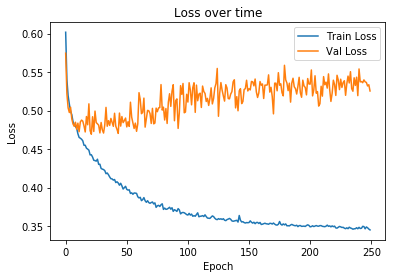

In [24]:
fig = plt.figure()
plt.title('Loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(averaged_train_loss_hist)), averaged_train_loss_hist, label='Train Loss')
plt.plot(range(len(averaged_val_loss_history)), averaged_val_loss_history, label='Val Loss')
plt.legend()

In [26]:
val_hist = np.asarray(val_iou_history)
train_hist = np.asarray(train_iou_history)

In [27]:
print(val_hist.shape)
print(train_hist.shape)

(6500, 2)
(6500, 2)


In [ ]:
fig = plt.figure()
plt.title('IOU for tumor over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(val_hist.shape[0]), val_hist[:,1], label='val')
plt.plot(range(train_hist.shape[0]), train_hist[:,1], label='train')
plt.legend()
# fig.savefig('IOU for tumor - Poster Session.png')

In [ ]:
fig = plt.figure()
plt.title('IOU for no tumor over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(val_hist.shape[0]), val_hist[:,0], label='val')
plt.plot(range(train_hist.shape[0]), train_hist[:,0], label='train')
plt.legend()
fig.savefig('IOU for no tumor - Poster Session.png')

In [ ]:
check_iou(test_loader, model)

Overfitting small dataset

In [ ]:
small_inputs = inputs[:40]
small_outputs = outputs[:40]

np.random.seed(0)
shuffled_idxs = list(range(small_inputs.shape[0]))
np.random.shuffle(shuffled_idxs)
train_cutoff = int(small_inputs.shape[0]*80/100)

small_train_inputs = []
small_train_outputs = []
small_val_inputs = []
small_val_outputs = []


for iteration, idx in enumerate(shuffled_idxs):
    if iteration < train_cutoff:
        small_train_inputs.append(small_inputs[idx])
        small_train_outputs.append(small_outputs[idx])
    else:
        small_val_inputs.append(small_inputs[idx])
        small_val_outputs.append(small_outputs[idx])

n_tumor_pixels = np.count_nonzero(np.asarray(small_train_outputs))
total_output_pixels = 32*32*32
frac_tumor = n_tumor_pixels / total_output_pixels


In [ ]:
small_train_inputs = np.asarray(small_train_inputs).astype(np.float32)
small_val_inputs = np.asarray(small_val_inputs).astype(np.float32)

small_train_inputs_mean = np.mean(small_train_inputs, axis=0)
small_train_inputs_std = np.std(small_train_inputs, axis=0)

small_train_inputs -= small_train_inputs_mean
small_train_inputs /= small_train_inputs_std
small_val_inputs -= small_train_inputs_mean
small_val_inputs /= small_train_inputs_std


In [ ]:
small_train_data = []
small_val_data = []
test_data = []

for idx in range(small_train_inputs.shape[0]):
    small_train_data.append([small_train_inputs[idx], small_train_outputs[idx]])
for idx in range(small_val_inputs.shape[0]):
    small_val_data.append([small_val_inputs[idx], small_val_outputs[idx]])

In [ ]:
print(len(small_train_data))
print(len(small_val_data))

In [ ]:
small_train_loader = torch.utils.data.DataLoader(small_train_data, shuffle=True, batch_size=32)
small_val_loader = torch.utils.data.DataLoader(small_val_data, shuffle=True, batch_size=32)


In [ ]:
print_every = 25
learning_rate = 1e-1
input_channels = 3
n_classes = 2
model = UNet(channel_in=input_channels, classes=n_classes)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
# criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, n_blank_pixel/float(n_tumor_pixels)]).cuda()) 
# criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, 35]).cuda()) 
criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, (total_output_pixels-n_tumor_pixels)/float(n_tumor_pixels)]).cuda()) 

# could try dice loss? not sure how it would work nor how it expects its parameters though lol

In [ ]:
val_iou_history = []
loss_history = []
train_iou_history = []
plot_every = 100
def train(model, optimizer, epochs=1):
    model = model.to(device=device)
    loss_history.clear()
    val_iou_history.clear()
    train_iou_history.clear()
    for e in range(epochs):
        for t, (x,y) in enumerate(small_train_loader):
            model.train()
            x = x.to(device='cuda', dtype=dtype)
            labels = y.to(device=device, dtype=torch.long).view(y.shape[0], 32, 32)
            # print(labels.shape)

            scores = model(x)
            # print(scores.shape)

            loss = criterion(scores, labels)
            # loss = F.cross_entropy(scores, labels, weight=torch.FloatTensor([1/(float(26265600-1762336)), 1/(float(1762336))]).cuda())
            loss_history.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # print(t)
            if t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                val_iou = check_iou(small_val_loader, model)
                val_iou_history.append(val_iou)
                train_iou = check_iou(small_train_loader, model)
                train_iou_history.append(train_iou)
                print('Validation IOU: ', val_iou)
                print('Training IOU: ', train_iou)
            # if t % plot_every == 0:
                # plot_output(scores, labels)
train(model, optimizer, epochs=5000)

In [ ]:
plt.title('Loss over time')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.plot(range(len(loss_history)), loss_history)

In [ ]:
val_hist = np.asarray(val_iou_history)
train_hist = np.asarray(train_iou_history)

In [ ]:
plt.title('IOU for tumor over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(val_hist.shape[0]), val_hist[:,1], label='val')
plt.plot(range(train_hist.shape[0]), train_hist[:,1], label='train')
plt.legend()

In [ ]:
plt.title('IOU for no tumor over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(val_hist.shape[0]), val_hist[:,0], label='val')
plt.plot(range(train_hist.shape[0]), train_hist[:,0], label='train')
plt.legend()